# 0. Package, Library, Mode

In [186]:
from pybaseball import statcast, cache
cache.enable()  # 캐시 사용 → 반복 호출 방지

import pandas as pd
import numpy as np

from IPython.display import display, HTML
from datetime import datetime, timedelta
import json, os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # 시각화 시 경고 메시지 제거
import shap

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint, mode
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier

In [187]:
# display option
pd.reset_option("all")

In [188]:
# EDITOR_MODE (vsc, colab) selection
EDITOR_MODE = 'vsc'

if EDITOR_MODE == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab 환경에서는 쉘 명령어로 pip 설치 가능
    !pip install -q pybaseball
    !pip install -q pyarrow
    !pip install -q xgboost
    !pip install -q lightgbm
    
elif EDITOR_MODE == 'vsc':
    pass

print("EDITOR_MODE : "+EDITOR_MODE)

EDITOR_MODE : vsc


# 1. Data Loader

In [189]:
COLAB_DATA_PATH = '/content/drive/MyDrive/'
VSC_DATA_PATH = '../data/'  # 상위 폴더

DATA_FILE_PATH = 'statcast_data.parquet'

INDICATOR_PATH = '../indicator/'  # 상위 폴더

if EDITOR_MODE == 'colab':
    file_path = COLAB_DATA_PATH + DATA_FILE_PATH
elif EDITOR_MODE == 'vsc':
    file_path = VSC_DATA_PATH + DATA_FILE_PATH
    
print("data path : "+file_path)

data path : ../data/statcast_data.parquet


In [190]:
# statcast data to parquet

'''
# API에서 데이터 받아서 parquet으로 저장

years = [2025]
all_data = []

for year in years:
    start_date = f"{year}-03-29" 
    end_date = f"{year}-07-31"

    print(f"Fetching data for {year}...")
    year_data = statcast(start_dt=start_date, end_dt=end_date)
    year_data["season"] = year
    all_data.append(year_data)

data = pd.concat(all_data, ignore_index=True)

data.to_parquet(file_path)

print("데이터 저장 완료")


'''



'\n# API에서 데이터 받아서 parquet으로 저장\n\nyears = [2025]\nall_data = []\n\nfor year in years:\n    start_date = f"{year}-03-29" \n    end_date = f"{year}-07-31"\n\n    print(f"Fetching data for {year}...")\n    year_data = statcast(start_dt=start_date, end_dt=end_date)\n    year_data["season"] = year\n    all_data.append(year_data)\n\ndata = pd.concat(all_data, ignore_index=True)\n\ndata.to_parquet(file_path)\n\nprint("데이터 저장 완료")\n\n\n'

In [191]:
print("data")
df = pd.read_parquet(file_path)
df

data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,season
0,SL,2024-03-29,85.4,-1.25,6.04,"Adam, Jason",595281,592094,None,swinging_strike,...,3.24,-0.06,0.06,33.3,<NA>,<NA>,<NA>,<NA>,<NA>,2024
1,FF,2024-03-29,96.1,-1.09,6.13,"Adam, Jason",672386,592094,None,called_strike,...,0.86,0.82,0.82,36.8,<NA>,<NA>,<NA>,<NA>,<NA>,2024
2,FF,2024-03-29,95.6,-1.35,5.96,"Adam, Jason",662139,592094,None,ball,...,0.89,0.71,-0.71,34.5,<NA>,<NA>,<NA>,<NA>,<NA>,2024
3,FF,2024-03-29,95.3,-1.13,6.13,"Adam, Jason",457759,592094,None,ball,...,1.08,0.94,0.94,37.4,<NA>,<NA>,<NA>,<NA>,<NA>,2024
4,SL,2024-03-29,87.1,-1.62,5.64,"Parsons, Wes",664040,641149,field_out,hit_into_play,...,2.68,-0.03,0.03,41.7,<NA>,<NA>,<NA>,<NA>,<NA>,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200615,SI,2025-08-07,93.9,1.23,5.38,"Simpson, Josh",595777,681006,None,foul,...,2.14,1.36,-1.36,<NA>,15.417441,-12.818561,28.456741,31.030153,41.830768,2025
1200616,FF,2025-08-07,97.9,-1.74,6.1,"Pérez, Eury",595777,691587,None,foul,...,1.04,0.41,-0.41,<NA>,-2.941746,28.812731,24.006739,40.662757,19.841486,2025
1200617,CH,2025-08-07,89.8,1.39,5.36,"Simpson, Josh",595777,681006,None,foul,...,2.93,1.09,-1.09,<NA>,14.495103,-19.324361,35.643608,26.186206,40.044748,2025
1200618,FF,2025-08-07,98.2,-1.7,6.08,"Pérez, Eury",595777,691587,walk,ball,...,1.01,1.09,-1.09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2025


In [192]:
# parquet update

'''
# 사용자 지정 구간
start_date = "2025-07-31"   # 새 데이터 시작일
end_date   = "2025-08-08"   # 새 데이터 종료일

# 파일 경로 (위에서 만든 file_path 재사용)
if not os.path.exists(file_path):
    raise FileNotFoundError(f"⚠️ {file_path} 파일이 없습니다. 먼저 기본 데이터를 생성하세요.")

# 기존 데이터 불러오기
df_old = pd.read_parquet(file_path)
print(f"기존 데이터: {df_old.shape} rows, {df_old['game_date'].min()} ~ {df_old['game_date'].max()}")

# 새 데이터 받아오기
print(f"새 데이터 요청 중... ({start_date} ~ {end_date})\n")
df_new = statcast(start_dt=start_date, end_dt=end_date)


if df_new.empty:
    print("⚠️ 새 데이터가 없습니다. 기간을 확인하세요.")
else:
    print(f"새 데이터 수집 완료: {df_new.shape} rows")

    # 시즌 컬럼 추가 (기존 형식 맞추기)
    df_new["season"] = pd.to_datetime(df_new["game_date"]).dt.year
    print(f"시즌 컬럼 추가: {df_new.shape} rows\n")

    # 기존 데이터와 합치기 + 중복 제거
    df_combined = pd.concat([df_old, df_new], ignore_index=True)

    # 날짜순 정렬
    df_combined.sort_values(by=["game_date", "game_pk", "pitch_number"], inplace=True)

    # 덮어쓰기 저장
    df_combined.to_parquet(file_path, index=False)
    print(f"✅ 데이터 업데이트 완료 → {file_path}")
    print(f"현재 데이터: {df_combined.shape} rows, {df_combined['game_date'].min()} ~ {df_combined['game_date'].max()}")


'''

'\n# 사용자 지정 구간\nstart_date = "2025-07-31"   # 새 데이터 시작일\nend_date   = "2025-08-08"   # 새 데이터 종료일\n\n# 파일 경로 (위에서 만든 file_path 재사용)\nif not os.path.exists(file_path):\n    raise FileNotFoundError(f"⚠️ {file_path} 파일이 없습니다. 먼저 기본 데이터를 생성하세요.")\n\n# 기존 데이터 불러오기\ndf_old = pd.read_parquet(file_path)\nprint(f"기존 데이터: {df_old.shape} rows, {df_old[\'game_date\'].min()} ~ {df_old[\'game_date\'].max()}")\n\n# 새 데이터 받아오기\nprint(f"새 데이터 요청 중... ({start_date} ~ {end_date})\n")\ndf_new = statcast(start_dt=start_date, end_dt=end_date)\n\n\nif df_new.empty:\n    print("⚠️ 새 데이터가 없습니다. 기간을 확인하세요.")\nelse:\n    print(f"새 데이터 수집 완료: {df_new.shape} rows")\n\n    # 시즌 컬럼 추가 (기존 형식 맞추기)\n    df_new["season"] = pd.to_datetime(df_new["game_date"]).dt.year\n    print(f"시즌 컬럼 추가: {df_new.shape} rows\n")\n\n    # 기존 데이터와 합치기 + 중복 제거\n    df_combined = pd.concat([df_old, df_new], ignore_index=True)\n\n    # 날짜순 정렬\n    df_combined.sort_values(by=["game_date", "game_pk", "pitch_number"], inplace=True)\n\n    # 덮어쓰

In [193]:
print("data")
df = pd.read_parquet(file_path)
df = df.sort_values(by=["game_date", "game_pk", "pitch_number"], ascending=[True, True, True]).reset_index(drop=True)
df

data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,season
0,SL,2024-03-29,85.4,-1.25,6.04,"Adam, Jason",595281,592094,None,swinging_strike,...,3.24,-0.06,0.06,33.3,<NA>,<NA>,<NA>,<NA>,<NA>,2024
1,FF,2024-03-29,96.1,-1.09,6.13,"Adam, Jason",672386,592094,None,called_strike,...,0.86,0.82,0.82,36.8,<NA>,<NA>,<NA>,<NA>,<NA>,2024
2,FF,2024-03-29,95.6,-1.35,5.96,"Adam, Jason",662139,592094,None,ball,...,0.89,0.71,-0.71,34.5,<NA>,<NA>,<NA>,<NA>,<NA>,2024
3,FF,2024-03-29,95.3,-1.13,6.13,"Adam, Jason",457759,592094,None,ball,...,1.08,0.94,0.94,37.4,<NA>,<NA>,<NA>,<NA>,<NA>,2024
4,SL,2024-03-29,87.1,-1.62,5.64,"Parsons, Wes",664040,641149,field_out,hit_into_play,...,2.68,-0.03,0.03,41.7,<NA>,<NA>,<NA>,<NA>,<NA>,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200615,SI,2025-08-07,93.9,1.23,5.38,"Simpson, Josh",595777,681006,None,foul,...,2.14,1.36,-1.36,<NA>,15.417441,-12.818561,28.456741,31.030153,41.830768,2025
1200616,FF,2025-08-07,97.9,-1.74,6.1,"Pérez, Eury",595777,691587,None,foul,...,1.04,0.41,-0.41,<NA>,-2.941746,28.812731,24.006739,40.662757,19.841486,2025
1200617,CH,2025-08-07,89.8,1.39,5.36,"Simpson, Josh",595777,681006,None,foul,...,2.93,1.09,-1.09,<NA>,14.495103,-19.324361,35.643608,26.186206,40.044748,2025
1200618,FF,2025-08-07,98.2,-1.7,6.08,"Pérez, Eury",595777,691587,walk,ball,...,1.01,1.09,-1.09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2025


In [194]:
# date_match_dict

# 날짜와 매치 정보 추출
df['game_date'] = pd.to_datetime(df['game_date'])
df['date_str'] = df['game_date'].dt.strftime('%y%m%d')

# 매치 ID: "AWAY@HOME" 형태로 생성
df['match_id'] = df['away_team'] + "@" + df['home_team']

# 날짜별 매치 집합 생성
date_match_dict = (
    df.groupby('date_str')['match_id']
    .agg(lambda x: sorted(set(x)))  # 정렬된 리스트로 저장
    .to_dict()
)



'''
# 저장 경로
match_json_path = "date_match_dict.json"

# JSON으로 저장
with open(match_json_path, "w") as f:
    json.dump(date_match_dict, f, indent=2)

print(f"✅ Saved match list by date to {match_json_path}")
'''

'\n# 저장 경로\nmatch_json_path = "date_match_dict.json"\n\n# JSON으로 저장\nwith open(match_json_path, "w") as f:\n    json.dump(date_match_dict, f, indent=2)\n\nprint(f"✅ Saved match list by date to {match_json_path}")\n'

In [195]:
print(type(date_match_dict))
# date_match_dict

<class 'dict'>


In [196]:
# pred_match_dict -> date_match_dict 에서 start, end 조절하고 내일 경기 손으로 집어 넣은 dict


# --- 설정 ---
match_json_path = "date_match_dict.json"  # 기존 전체 매치 JSON
pred_json_path = "pred_match_dict.json"   # 추출된 매치 JSON

start_date = "250522"  # YYMMDD 형식
end_date   = "250807"  # YYMMDD 형식

# --- 로드 ---
with open(match_json_path, "r") as f:
    date_match_dict = json.load(f)

# --- 필터링 ---
pred_match_dict = {
    date: matches
    for date, matches in date_match_dict.items()
    if start_date <= date <= end_date
}

# --- 저장 ---
with open(pred_json_path, "w") as f:
    json.dump(pred_match_dict, f, indent=2, ensure_ascii=False)

print(f"✅ Saved {len(pred_match_dict)} days of matches to {pred_json_path}")
print("날짜 범위:", start_date, "~", end_date)



✅ Saved 74 days of matches to pred_match_dict.json
날짜 범위: 250522 ~ 250807


In [197]:
display(df)
# date_str, match_id 추가됨

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,season,date_str,match_id
0,SL,2024-03-29,85.4,-1.25,6.04,"Adam, Jason",595281,592094,None,swinging_strike,...,0.06,33.3,<NA>,<NA>,<NA>,<NA>,<NA>,2024,240329,TOR@TB
1,FF,2024-03-29,96.1,-1.09,6.13,"Adam, Jason",672386,592094,None,called_strike,...,0.82,36.8,<NA>,<NA>,<NA>,<NA>,<NA>,2024,240329,TOR@TB
2,FF,2024-03-29,95.6,-1.35,5.96,"Adam, Jason",662139,592094,None,ball,...,-0.71,34.5,<NA>,<NA>,<NA>,<NA>,<NA>,2024,240329,TOR@TB
3,FF,2024-03-29,95.3,-1.13,6.13,"Adam, Jason",457759,592094,None,ball,...,0.94,37.4,<NA>,<NA>,<NA>,<NA>,<NA>,2024,240329,TOR@TB
4,SL,2024-03-29,87.1,-1.62,5.64,"Parsons, Wes",664040,641149,field_out,hit_into_play,...,0.03,41.7,<NA>,<NA>,<NA>,<NA>,<NA>,2024,240329,TOR@TB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200615,SI,2025-08-07,93.9,1.23,5.38,"Simpson, Josh",595777,681006,None,foul,...,-1.36,<NA>,15.417441,-12.818561,28.456741,31.030153,41.830768,2025,250807,MIA@ATL
1200616,FF,2025-08-07,97.9,-1.74,6.1,"Pérez, Eury",595777,691587,None,foul,...,-0.41,<NA>,-2.941746,28.812731,24.006739,40.662757,19.841486,2025,250807,MIA@ATL
1200617,CH,2025-08-07,89.8,1.39,5.36,"Simpson, Josh",595777,681006,None,foul,...,-1.09,<NA>,14.495103,-19.324361,35.643608,26.186206,40.044748,2025,250807,MIA@ATL
1200618,FF,2025-08-07,98.2,-1.7,6.08,"Pérez, Eury",595777,691587,walk,ball,...,-1.09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2025,250807,MIA@ATL


# 2. Preprocessing

## 2-1 drop, fill, X y split

In [198]:
df_prepro = df.copy() 

In [199]:
# df features name print
def print_columns_in_blocks(df, block_size=5): 
    cols = df.columns.tolist()
    print(f"총 컬럼 수: {len(cols)}\n")

    for i in range(0, len(cols), block_size):
        print(", ".join(cols[i:i+block_size]))


print_columns_in_blocks(df)

총 컬럼 수: 121

pitch_type, game_date, release_speed, release_pos_x, release_pos_z
player_name, batter, pitcher, events, description
spin_dir, spin_rate_deprecated, break_angle_deprecated, break_length_deprecated, zone
des, game_type, stand, p_throws, home_team
away_team, type, hit_location, bb_type, balls
strikes, game_year, pfx_x, pfx_z, plate_x
plate_z, on_3b, on_2b, on_1b, outs_when_up
inning, inning_topbot, hc_x, hc_y, tfs_deprecated
tfs_zulu_deprecated, umpire, sv_id, vx0, vy0
vz0, ax, ay, az, sz_top
sz_bot, hit_distance_sc, launch_speed, launch_angle, effective_speed
release_spin_rate, release_extension, game_pk, fielder_2, fielder_3
fielder_4, fielder_5, fielder_6, fielder_7, fielder_8
fielder_9, release_pos_y, estimated_ba_using_speedangle, estimated_woba_using_speedangle, woba_value
woba_denom, babip_value, iso_value, launch_speed_angle, at_bat_number
pitch_number, pitch_name, home_score, away_score, bat_score
fld_score, post_away_score, post_home_score, post_bat_score, post_fld

In [200]:
# df features missing rate csv
def save_missing_report_csv(df, filename, round_ndigits=2):
    # round_ndigits: 결측률 반올림 자리수 (기본 2)

    total_rows = len(df)
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / total_rows) * 100
    dtypes = df.dtypes
    sample_values = df.apply(lambda col: col.dropna().iloc[0] if col.dropna().size > 0 else None)

    report = pd.DataFrame({
        'Feature': df.columns,
        'Missing Count': missing_count.values,
        'Missing %': missing_percent.round(round_ndigits).values,
        'Dtype': dtypes.values,
        'Sample Value': sample_values.values
    })

    report.to_csv(INDICATOR_PATH + filename, index=False)
    print(f"저장 완료: {filename} (Colab 왼쪽 '파일탭'에서 다운로드 가능)")
    
# save_missing_report_csv(df_prepro, filename="2-1 missing_report.csv")

In [201]:

# meta, drop 분리
meta_features = [
    'game_pk',
    'inning', 'inning_topbot',
    'pitch_number',  # 이 타석 내에서의 투구 번호
    
    'home_team', 'away_team',
    'game_date',
    'batter', 'pitcher',
    'post_home_score', 'post_away_score',  # 최종 점수 → label
    'home_score', 'away_score',
    'events',
    
    'date_str', 'match_id'
]


drop_features = [
    #
    'player_name',
    'description',
    
    # 사용되지 않는 deprecated
    'spin_dir', 'spin_rate_deprecated',
    'break_angle_deprecated', 'break_length_deprecated',
    'tfs_deprecated', 'tfs_zulu_deprecated',
    
    #
    'des',
    'umpire',
    'sv_id',
    'pitcher_days_until_next_game', 'batter_days_until_next_game',
    
    # 중복 또는 의미 중복
    'age_pit_legacy', 
    'age_bat_legacy', 
    'home_score_diff',

    # 타겟 정보 포함 가능성 (데이터 누수 우려)
    'post_bat_score', 'post_fld_score',
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp',
    'home_win_exp', 'bat_win_exp',
    'bat_score', 'fld_score',
    
    # 단일 시즌 훈련 시 불필요
    'game_year', 'season',
    
    # fielder
    'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
    
    # drop by missing (missing over 50%)
    'hit_location', 'bb_type',
    'on_3b', 'on_2b', 'on_1b',
    'hc_x', 'hc_y',
    'hit_distance_sc',
    'launch_speed', 'launch_angle', 'launch_speed_angle',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
    'woba_value', 'woba_denom',
    'babip_value', 'iso_value',
    'bat_speed',
    'swing_length',
    'estimated_slg_using_speedangle',
    'hyper_speed',
    'attack_angle', 'attack_direction',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches',
    
    # 
    
]



print("meta_features len : " + str(len(meta_features)))
print("drop_features len : " + str(len(drop_features)))

meta_features len : 16
drop_features len : 61


In [202]:
def preprocess_X_meta_y(df_prepro, meta_features, drop_features):
    # 1. meta
    df_meta = df_prepro[meta_features].copy()
    
    # 2. X
    df_drop = df_prepro.drop(columns=meta_features + drop_features)

    # 3. y
    
    def assign_label(row):
        if row['post_home_score'] > row['post_away_score']:
            return 1   # 홈 승
        elif row['post_home_score'] < row['post_away_score']:
            return 0   # 원정 승
        else:
            return 1   # 무승부는 홈 승 처리
        
    y = df_meta.groupby('game_pk').agg({
        'date_str': 'first',
        'match_id': 'first',
        
        'home_team': 'first',
        'away_team': 'first',
        
        'post_home_score': 'max',
        'post_away_score': 'max',
    }).reset_index()
    
    y['label'] = y.apply(assign_label, axis=1)
    
    return df_drop, df_meta, y

# X, y(label) split
X, meta, y = preprocess_X_meta_y(df_prepro, meta_features, drop_features)

In [203]:
# meta에서 고유 game_pk 순서 리스트
game_pk_order = meta['game_pk'].drop_duplicates().tolist()

# df_y를 game_pk 순서에 맞춰 재정렬
y = y.set_index('game_pk').loc[game_pk_order].reset_index()

In [204]:
# X, meta, y    shape
dataset_shapes = {
    "df": (X, meta, y),
}

# 결과를 저장할 리스트
summary = []

# 각 데이터셋에 대해 shape 정보 수집
for name, (X, meta, y) in dataset_shapes.items():
    summary.append({
        "Set": name,
        "X Shape": X.shape,
        "Meta Shape": meta.shape,
        "y Shape": y.shape
    })

# DataFrame으로 정리해서 출력
shape_df = pd.DataFrame(summary)
display(shape_df)


,Set,X Shape,Meta Shape,y Shape
0,df,"(1200620, 44)","(1200620, 16)","(4115, 8)"


In [205]:
# df meta excel

'''
# 상위 10개 샘플을 뽑기
sample_count = 10
meta_samples = {}

for col in meta.columns:
    meta_samples[col] = list(meta[col].head(sample_count))

# DataFrame으로 변환
df_meta_samples = pd.DataFrame(meta_samples)

# ✅ 엑셀로 저장 (원하면)
output_path = INDICATOR_PATH+"2-1 meta_sample_10.xlsx"
df_meta_samples.to_excel(output_path, index=False)
'''

'\n# 상위 10개 샘플을 뽑기\nsample_count = 10\nmeta_samples = {}\n\nfor col in meta.columns:\n    meta_samples[col] = list(meta[col].head(sample_count))\n\n# DataFrame으로 변환\ndf_meta_samples = pd.DataFrame(meta_samples)\n\n# ✅ 엑셀로 저장 (원하면)\noutput_path = INDICATOR_PATH+"2-1 meta_sample_10.xlsx"\ndf_meta_samples.to_excel(output_path, index=False)\n'

In [206]:
# df y excel

'''
output_path = INDICATOR_PATH + "2-1 y_summary.xlsx"
y.to_excel(output_path, index=False)
'''


'\noutput_path = INDICATOR_PATH + "2-1 y_summary.xlsx"\ny.to_excel(output_path, index=False)\n'

In [207]:
def check_topbot_pairing(meta, name):
    counts = meta.groupby("game_pk")["inning_topbot"].nunique()
    result = {
        "Set": name,
        "Total Games": len(counts),
        "Both Top/Bottom": (counts == 2).sum(),
        "Only Top or Bottom": (counts < 2).sum()
    }
    return result


# 모든 세트 검사
topbot_summary = pd.DataFrame([
    check_topbot_pairing(meta, "df")
])


# 표 형태로 출력
display(topbot_summary)

,Set,Total Games,Both Top/Bottom,Only Top or Bottom
0,df,4115,4115,0


In [208]:
# label 통계 계산
label_1_count = (y['label'] == 1).sum()
label_0_count = (y['label'] == 0).sum()
label_1_pct = (label_1_count / len(y)) * 100
label_0_pct = (label_0_count / len(y)) * 100

# 결과를 DataFrame으로 정리
stats_df = pd.DataFrame({
    'Metric': ['y_shape', 'label_1_count', 'label_0_count', 'label_1_pct', 'label_0_pct'],
    'Value': [f"{y.shape[0]} x {y.shape[1]}", label_1_count, label_0_count, f"{label_1_pct:.2f}%", f"{label_0_pct:.2f}%"]
})

# 표 형태로 출력
display(stats_df)


,Metric,Value
0,y_shape,4115 x 8
1,label_1_count,2188
2,label_0_count,1927
3,label_1_pct,53.17%
4,label_0_pct,46.83%


In [209]:
print_columns_in_blocks(X)

총 컬럼 수: 44

pitch_type, release_speed, release_pos_x, release_pos_z, zone
game_type, stand, p_throws, type, balls
strikes, pfx_x, pfx_z, plate_x, plate_z
outs_when_up, vx0, vy0, vz0, ax
ay, az, sz_top, sz_bot, effective_speed
release_spin_rate, release_extension, release_pos_y, at_bat_number, pitch_name
if_fielding_alignment, of_fielding_alignment, spin_axis, bat_score_diff, age_pit
age_bat, n_thruorder_pitcher, n_priorpa_thisgame_player_at_bat, pitcher_days_since_prev_game, batter_days_since_prev_game
api_break_z_with_gravity, api_break_x_arm, api_break_x_batter_in, arm_angle


In [210]:
# X fill

X_missing = X

# 1) 평균으로 채우는 컬럼
fill_mean_cols = [
    'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
    'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
    'release_extension', 'release_pos_y', 'spin_axis', 'api_break_z_with_gravity',
    'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle'
]

for col in fill_mean_cols:
    mean_val = X_missing[col].mean()
    # Int64 타입은 정수로 변환 후 fill
    if pd.api.types.is_integer_dtype(X_missing[col].dtype):
        mean_val = int(round(mean_val))

    X_missing[col].fillna(mean_val, inplace=True)


# 2) 최빈값으로 채우는 컬럼
fill_mode_cols = ['zone']
for col in fill_mode_cols:
    mode_val = X_missing[col].mode().iloc[0]

    X_missing[col].fillna(mode_val, inplace=True)


# 3) 'Unknown' 또는 최빈값으로 채우는 object 타입 컬럼
fill_unknown_cols = ['pitch_type', 'pitch_name']
for col in fill_unknown_cols:
    X_missing[col].fillna('Unknown', inplace=True)


# 4) 고정값으로 채우는 컬럼
fill_constant = {
    'if_fielding_alignment': 'Standard',
    'of_fielding_alignment': 'Standard',
    'pitcher_days_since_prev_game': 0,
    'batter_days_since_prev_game': 0
}

for col, val in fill_constant.items():
    X_missing[col].fillna(val, inplace=True)


# 고정값 컬럼 리스트 정의 (keys만 사용)
fill_constant_cols = list(fill_constant.keys())

# 총 컬럼 개수 계산
total_fill_cols = len(fill_mean_cols + fill_mode_cols + fill_unknown_cols + fill_constant_cols)
print("filled len :", total_fill_cols)


filled len : 31


In [211]:
# X_missing -> fill check (결측치 전부 0인지 확인)
datasets = {
    "X_missing": X_missing,
}

# 결측치가 모두 0개인지 확인
for name, df in datasets.items():
    missing_per_col = df.isnull().sum()
    if (missing_per_col == 0).all():
        print(f"{name} every feature missing 0%")
    else:
        print(f"{name} has missing values:")
        print(missing_per_col[missing_per_col > 0])


X_missing every feature missing 0%


In [212]:
# X_missing 10 sample 

sample_data = []

# 각 컬럼별 상위 10개 샘플 추출
for col in X_missing.columns:
    top_samples = X_missing[col].head(10).tolist()  # 상위 10개 값
    sample_data.append([col] + top_samples)

# DataFrame으로 변환
# 첫 번째 컬럼은 'column_name', 이후는 sample_1, sample_2, ...
sample_df = pd.DataFrame(sample_data, columns=['column_name'] + [f'sample_{i+1}' for i in range(10)])

# Excel로 저장
output_file = INDICATOR_PATH + "2-1 X_missing_top10_samples.xlsx"
sample_df.to_excel(output_file, index=False)

## 2-2 Encoding

In [213]:
# 복사본 생성 (원본 보존)
X_encoded = X_missing.copy()

In [214]:
# 1. Label Encoding (공통)

# 인코딩할 컬럼 목록
label_encode_cols = ['pitch_type', 'type', 'zone', 'pitch_name']


# 1. 인코딩 전 데이터 복사 (Before 저장용)
X_encoded = X_missing.copy()  # X_missing에서 fill된 데이터 사용
before_samples = X_encoded[label_encode_cols].copy()

# 2. 문자열 변환 (카테고리가 숫자로 바뀌는 문제 방지)
for col in label_encode_cols:
    X_encoded[col] = X_encoded[col].astype(str)

# 3. OrdinalEncoder로 인코딩
# OrdinalEncoder 인스턴스 생성 (unknown → -1로 처리)
# fit + transform (전체 X_encoded 기준)
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded[label_encode_cols] = ordinal_enc.fit_transform(X_encoded[label_encode_cols])


# Label Encoding excel
'''
# 4. Sheet1: Before-After 비교 (상위 10개)
sample_count = 10
compare_df = pd.DataFrame()

for col in label_encode_cols:
    compare_df[f"{col} (before)"] = before_samples[col].head(sample_count).values
    compare_df[f"{col} (after)"] = X_encoded[col].head(sample_count).astype(int).values


# 5. Sheet2~Sheet5: 각 컬럼별 매핑 테이블
mapping_dfs = {}
for i, col in enumerate(label_encode_cols):
    mapping_dfs[col] = pd.DataFrame({
        "category": ordinal_enc.categories_[i],
        "encoded_value": range(len(ordinal_enc.categories_[i]))
    })

# 6. Excel로 저장
with pd.ExcelWriter(INDICATOR_PATH+"2-2 label_encoding_summary.xlsx") as writer:
    compare_df.to_excel(writer, sheet_name="Before_After_Sample", index=False)
    for col in label_encode_cols:
        mapping_dfs[col].to_excel(writer, sheet_name=f"Mapping_{col}", index=False)
'''


'\n# 4. Sheet1: Before-After 비교 (상위 10개)\nsample_count = 10\ncompare_df = pd.DataFrame()\n\nfor col in label_encode_cols:\n    compare_df[f"{col} (before)"] = before_samples[col].head(sample_count).values\n    compare_df[f"{col} (after)"] = X_encoded[col].head(sample_count).astype(int).values\n\n\n# 5. Sheet2~Sheet5: 각 컬럼별 매핑 테이블\nmapping_dfs = {}\nfor i, col in enumerate(label_encode_cols):\n    mapping_dfs[col] = pd.DataFrame({\n        "category": ordinal_enc.categories_[i],\n        "encoded_value": range(len(ordinal_enc.categories_[i]))\n    })\n\n# 6. Excel로 저장\nwith pd.ExcelWriter(INDICATOR_PATH+"2-2 label_encoding_summary.xlsx") as writer:\n    compare_df.to_excel(writer, sheet_name="Before_After_Sample", index=False)\n    for col in label_encode_cols:\n        mapping_dfs[col].to_excel(writer, sheet_name=f"Mapping_{col}", index=False)\n'

In [215]:
'''
fit()
학습 데이터를 기준으로 라벨 인코딩의 매핑 규칙을 만든다
예: ['FF', 'SL', 'CU'] → [0, 1, 2]

transform()
이미 만든 매핑 규칙을 이용해서 실제 값을 변환한다
예: 'SL' → 1
'''

"\nfit()\n학습 데이터를 기준으로 라벨 인코딩의 매핑 규칙을 만든다\n예: ['FF', 'SL', 'CU'] → [0, 1, 2]\n\ntransform()\n이미 만든 매핑 규칙을 이용해서 실제 값을 변환한다\n예: 'SL' → 1\n"

In [216]:
print(X_encoded.shape)

(1200620, 44)


In [217]:
# 2. One-Hot Encoding
one_hot_cols = ['game_type', 'stand', 'p_throws', 'if_fielding_alignment', 'of_fielding_alignment']

# 1) 전체 가능한 dummy 컬럼 추출 (기준: X_encoded 전체 데이터)
dummy_all_columns = pd.get_dummies(X_encoded[one_hot_cols], columns=one_hot_cols).columns.tolist()

# 2) X_encoded에 대해 One-Hot Encoding 수행
df_dummies = pd.get_dummies(X_encoded[one_hot_cols], columns=one_hot_cols)

# 3) 누락된 컬럼 보정 (0으로 채우기)
for col in dummy_all_columns:
    if col not in df_dummies.columns:
        df_dummies[col] = 0

# 4) 컬럼 순서 맞춤
df_dummies = df_dummies[dummy_all_columns]

# 5) 기존 원본에서 one_hot_cols 삭제하고, 인코딩 결과 합치기
X_encoded = pd.concat([X_encoded.drop(columns=one_hot_cols), df_dummies], axis=1)


print(X_encoded.shape)

# 드롭 대상 컬럼 (희귀 + 불균형)
rare_alignment_cols = [
    'if_fielding_alignment_Infield shade',
    # 의미 : 미세한 내야 위치 조정
    # 빈도 : 희귀	
    # 중요도 : 낮음
    'of_fielding_alignment_4th outfielder'
    # 4명 외야수 배치 (전략적)	
    # 매우 희귀	
    # 매우 낮음 
]

X_encoded.drop(columns=rare_alignment_cols, errors='ignore', inplace=True)
print(f"✅ One-Hot Encoding 완료 (희귀 컬럼 제거 후): {X_encoded.shape}")


# One-Hot Encoding excel
'''
# One-Hot Encoding 확인
# (1) Sheet1: One-Hot Encoding 전 10개 샘플
sheet1 = X_missing[one_hot_cols].head(10).copy()

# (2) Sheet2: One-Hot Encoding 후 10개 샘플
sheet2 = df_dummies.drop(columns=rare_alignment_cols, errors='ignore').head(10).copy()

# Excel로 저장
with pd.ExcelWriter(INDICATOR_PATH+"2-2 onehot_encoding_summary.xlsx") as writer:
    sheet1.to_excel(writer, sheet_name="Before_OneHot", index=False)
    sheet2.to_excel(writer, sheet_name="After_OneHot", index=False)

print("✅ One-Hot Encoding 비교 결과 저장 완료 → onehot_encoding_summary.xlsx")
'''

(1200620, 50)
✅ One-Hot Encoding 완료 (희귀 컬럼 제거 후): (1200620, 48)


'\n# One-Hot Encoding 확인\n# (1) Sheet1: One-Hot Encoding 전 10개 샘플\nsheet1 = X_missing[one_hot_cols].head(10).copy()\n\n# (2) Sheet2: One-Hot Encoding 후 10개 샘플\nsheet2 = df_dummies.drop(columns=rare_alignment_cols, errors=\'ignore\').head(10).copy()\n\n# Excel로 저장\nwith pd.ExcelWriter(INDICATOR_PATH+"2-2 onehot_encoding_summary.xlsx") as writer:\n    sheet1.to_excel(writer, sheet_name="Before_OneHot", index=False)\n    sheet2.to_excel(writer, sheet_name="After_OneHot", index=False)\n\nprint("✅ One-Hot Encoding 비교 결과 저장 완료 → onehot_encoding_summary.xlsx")\n'

In [218]:
'''
pd.get_dummies()는 주어진 데이터에서 존재하는 값들만 기준으로 One-Hot Encoding을 수행

**stand**는 원래 컬럼 이름이고,
**stand_L, stand_R**  는 접두사(prefix)로 사용되어 만들어진 결과 컬럼
'''

'''
encoded_cols = [col for col in X_train_encoded.columns if col.startswith(prefix + '_')]
[<반환할 항목> for <항목> in <반복 대상> if <조건>]


if col.startswith(prefix + '_')
이 부분은 각 컬럼 이름이 특정 접두사로 시작하는지 확인합니다.

'stand_L'.startswith('stand_')  # True
'stand_R'.startswith('stand_')  # True
'pitch_type'.startswith('stand_')  # False
'''

"\nencoded_cols = [col for col in X_train_encoded.columns if col.startswith(prefix + '_')]\n[<반환할 항목> for <항목> in <반복 대상> if <조건>]\n\n\nif col.startswith(prefix + '_')\n이 부분은 각 컬럼 이름이 특정 접두사로 시작하는지 확인합니다.\n\n'stand_L'.startswith('stand_')  # True\n'stand_R'.startswith('stand_')  # True\n'pitch_type'.startswith('stand_')  # False\n"

In [219]:
print_columns_in_blocks(X_encoded)

총 컬럼 수: 48

pitch_type, release_speed, release_pos_x, release_pos_z, zone
type, balls, strikes, pfx_x, pfx_z
plate_x, plate_z, outs_when_up, vx0, vy0
vz0, ax, ay, az, sz_top
sz_bot, effective_speed, release_spin_rate, release_extension, release_pos_y
at_bat_number, pitch_name, spin_axis, bat_score_diff, age_pit
age_bat, n_thruorder_pitcher, n_priorpa_thisgame_player_at_bat, pitcher_days_since_prev_game, batter_days_since_prev_game
api_break_z_with_gravity, api_break_x_arm, api_break_x_batter_in, arm_angle, game_type_R
stand_L, stand_R, p_throws_L, p_throws_R, if_fielding_alignment_Standard
if_fielding_alignment_Strategic, of_fielding_alignment_Standard, of_fielding_alignment_Strategic


## 2-3 Outlier

In [220]:
#

## 2-4 Feature Engineering

In [221]:
X_FE = X_encoded.copy()

# time_aware_feature (빈 df로 초기화)
X_taf = pd.DataFrame(index=X_encoded.index)

In [222]:
def create_time_aware_feature(X): # 주어진 encoded dataframe에서 파생 피처 및 time-aware 를 생성하여 df_taf에 덮어씌움
    
    # 2) time operation
    def generate_time_features(base_series, prefix):
        return {
            f"{prefix}_rolling_avg_5": base_series.rolling(window=5, min_periods=1).mean(),
            f"{prefix}_lag_1": base_series.shift(1),
            f"{prefix}_diff_1": base_series.diff(),
        }
    # derived feature + time operation -> time aware feature

    all_features = []

    # 1) derived feature
    spin_eff = X["release_spin_rate"] / X["release_speed"]
    all_features.append(pd.DataFrame(generate_time_features(spin_eff, "spin_efficiency"), index=X.index))

    speed_gap = X["release_speed"] - X["effective_speed"]
    all_features.append(pd.DataFrame(generate_time_features(speed_gap, "speed_gap"), index=X.index))

    release_pos_angle = np.arctan(X["release_pos_z"] / (X["release_pos_x"] + 1e-6))
    all_features.append(pd.DataFrame(generate_time_features(release_pos_angle, "release_pos_angle"), index=X.index))

    plate_distance = np.sqrt(X["plate_x"]**2 + X["plate_z"]**2)
    all_features.append(pd.DataFrame(generate_time_features(plate_distance, "plate_distance"), index=X.index))

    init_velocity_vector = np.sqrt(X["vx0"]**2 + X["vy0"]**2 + X["vz0"]**2)
    all_features.append(pd.DataFrame(generate_time_features(init_velocity_vector, "init_velocity_vector"), index=X.index))

    pitch_movement_vector = np.sqrt(X["pfx_x"]**2 + X["pfx_z"]**2)
    all_features.append(pd.DataFrame(generate_time_features(pitch_movement_vector, "pitch_movement_vector"), index=X.index))

    speed_per_extension = X["release_speed"] / (X["release_extension"] + 1e-6)
    all_features.append(pd.DataFrame(generate_time_features(speed_per_extension, "speed_per_extension"), index=X.index))

    release_mechanics_profile = X["release_pos_y"] + X["release_extension"]
    all_features.append(pd.DataFrame(generate_time_features(release_mechanics_profile, "release_mechanics_profile"), index=X.index))

    vertical_spin_effect = X["spin_axis"] * X["pfx_z"]
    all_features.append(pd.DataFrame(generate_time_features(vertical_spin_effect, "vertical_spin_effect"), index=X.index))

    # 10.
    horizontal_spin_effect = X["release_spin_rate"] / (X["pfx_x"] + 1e-6)
    all_features.append(pd.DataFrame(generate_time_features(horizontal_spin_effect, "horizontal_spin_effect"), index=X.index))

    df_taf = pd.concat(all_features, axis=1)
    return df_taf

X_taf = create_time_aware_feature(X_encoded)

In [223]:
'''
1. Rolling Average: rolling(window=5, min_periods=1).mean()

과거 5개의 값을 평균해서 현재 시점의 이동 평균을 계산합니다.
즉, t 시점의 값은 t, t-1, ..., t-4까지의 평균입니다.
min_periods=1 덕분에 앞에 데이터가 부족할 때도 계산됨 (예: t=2면 2개만 평균).

| 시점 (t) | 값  | rolling 평균 (5)           |
| ------ | -- | ------------------------ |
| 0      | 10 | 10                       |
| 1      | 12 | (10+12)/2 = 11           |
| 2      | 9  | (10+12+9)/3 = 10.33      |
| 3      | 14 | (10+12+9+14)/4 = 11.25   |
| 4      | 13 | (10+12+9+14+13)/5 = 11.6 |
| 5      | 8  | (12+9+14+13+8)/5 = 11.2  |

2. Lag (Shift): shift(1)

값을 한 칸 뒤로 밀어 과거 값을 현재 위치로 가져옵니다.
t 시점에 t-1의 값을 넣는 구조.
시계열에서 **"직전 값"**을 참조할 때 자주 사용됩니다.

| 시점 (t) | 값  | lag\_1 |
| ------ | -- | ------ |
| 0      | 10 | NaN    |
| 1      | 12 | 10     |
| 2      | 9  | 12     |
| 3      | 14 | 9      |
| 4      | 13 | 14     |

3. Difference from Previous: diff()

현재 값에서 이전 값을 뺀 차이값을 구합니다.
즉, 변화량을 측정합니다. (변화 추이 파악)

| 시점 (t) | 값  | diff\_1 = 값\[t] - 값\[t-1] |
| ------ | -- | ------------------------- |
| 0      | 10 | NaN                       |
| 1      | 12 | 2                         |
| 2      | 9  | -3                        |
| 3      | 14 | 5                         |
| 4      | 13 | -1                        |

# rolling average와 diff는 노이즈 제거, 추세 파악에 매우 유용
'''

'\n1. Rolling Average: rolling(window=5, min_periods=1).mean()\n\n과거 5개의 값을 평균해서 현재 시점의 이동 평균을 계산합니다.\n즉, t 시점의 값은 t, t-1, ..., t-4까지의 평균입니다.\nmin_periods=1 덕분에 앞에 데이터가 부족할 때도 계산됨 (예: t=2면 2개만 평균).\n\n| 시점 (t) | 값  | rolling 평균 (5)           |\n| ------ | -- | ------------------------ |\n| 0      | 10 | 10                       |\n| 1      | 12 | (10+12)/2 = 11           |\n| 2      | 9  | (10+12+9)/3 = 10.33      |\n| 3      | 14 | (10+12+9+14)/4 = 11.25   |\n| 4      | 13 | (10+12+9+14+13)/5 = 11.6 |\n| 5      | 8  | (12+9+14+13+8)/5 = 11.2  |\n\n2. Lag (Shift): shift(1)\n\n값을 한 칸 뒤로 밀어 과거 값을 현재 위치로 가져옵니다.\nt 시점에 t-1의 값을 넣는 구조.\n시계열에서 **"직전 값"**을 참조할 때 자주 사용됩니다.\n\n| 시점 (t) | 값  | lag\\_1 |\n| ------ | -- | ------ |\n| 0      | 10 | NaN    |\n| 1      | 12 | 10     |\n| 2      | 9  | 12     |\n| 3      | 14 | 9      |\n| 4      | 13 | 14     |\n\n3. Difference from Previous: diff()\n\n현재 값에서 이전 값을 뺀 차이값을 구합니다.\n즉, 변화량을 측정합니다. (변화 추이 파악)\n\n| 시점 (t) | 값  | diff\\_1 = 값\\[t] - 값\\[t-1]

In [224]:
# X taf shape 확인
print("X_taf shape:", X_taf.shape)

X_taf shape: (1200620, 30)


In [225]:

taf_cols = list(X_taf.columns)

print(f"🧩 총 {len(taf_cols)}개의 TAF 컬럼:\n")

for i in range(0, len(taf_cols), 3):
    group = taf_cols[i:i+3]
    print(', '.join(group))


🧩 총 30개의 TAF 컬럼:

spin_efficiency_rolling_avg_5, spin_efficiency_lag_1, spin_efficiency_diff_1
speed_gap_rolling_avg_5, speed_gap_lag_1, speed_gap_diff_1
release_pos_angle_rolling_avg_5, release_pos_angle_lag_1, release_pos_angle_diff_1
plate_distance_rolling_avg_5, plate_distance_lag_1, plate_distance_diff_1
init_velocity_vector_rolling_avg_5, init_velocity_vector_lag_1, init_velocity_vector_diff_1
pitch_movement_vector_rolling_avg_5, pitch_movement_vector_lag_1, pitch_movement_vector_diff_1
speed_per_extension_rolling_avg_5, speed_per_extension_lag_1, speed_per_extension_diff_1
release_mechanics_profile_rolling_avg_5, release_mechanics_profile_lag_1, release_mechanics_profile_diff_1
vertical_spin_effect_rolling_avg_5, vertical_spin_effect_lag_1, vertical_spin_effect_diff_1
horizontal_spin_effect_rolling_avg_5, horizontal_spin_effect_lag_1, horizontal_spin_effect_diff_1


In [226]:
# X taf missing 확인

taf_dfs = {
    "X_taf": X_taf,
}

# 결측 있는 컬럼만 출력
for name, df in taf_dfs.items():
    missing_cols = df.columns[df.isnull().any()]
    if len(missing_cols) > 0:
        print(f"🔍 {name} has missing values in:")
        print(df[missing_cols].isnull().sum())
        print("-" * 40)
    else:
        print(f"✅ {name} has no missing values.")


🔍 X_taf has missing values in:
spin_efficiency_lag_1               1
spin_efficiency_diff_1              1
speed_gap_lag_1                     1
speed_gap_diff_1                    1
release_pos_angle_lag_1             1
release_pos_angle_diff_1            1
plate_distance_lag_1                1
plate_distance_diff_1               1
init_velocity_vector_lag_1          1
init_velocity_vector_diff_1         1
pitch_movement_vector_lag_1         1
pitch_movement_vector_diff_1        1
speed_per_extension_lag_1           1
speed_per_extension_diff_1          1
release_mechanics_profile_lag_1     1
release_mechanics_profile_diff_1    1
vertical_spin_effect_lag_1          1
vertical_spin_effect_diff_1         1
horizontal_spin_effect_lag_1        1
horizontal_spin_effect_diff_1       1
dtype: int64
----------------------------------------


In [227]:
# 결측값을 "아래 행의 값으로 채우는 방식" (backward fill)**
'''
첫 번째 행만 NaN인 경우가 대부분 (lag, diff 연산 때문)
모델 입력에 결측이 없어야 하므로, 가장 가까운 다음 값으로 복구함
'''

for df in [X_taf]:
    df.fillna(method="bfill", inplace=True)


In [228]:
# X taf missing 확인

taf_dfs = {
    "X_taf": X_taf,
}

# 결측 있는 컬럼만 출력
for name, df in taf_dfs.items():
    missing_cols = df.columns[df.isnull().any()]
    if len(missing_cols) > 0:
        print(f"🔍 {name} has missing values in:")
        print(df[missing_cols].isnull().sum())
        print("-" * 40)
    else:
        print(f"✅ {name} has no missing values.")


✅ X_taf has no missing values.


In [229]:
# taf feature 중 FE에 넣을 것 선택
selected_taf_cols = [
    'spin_efficiency_rolling_avg_5',
    'speed_gap_diff_1',
    'pitch_movement_vector_rolling_avg_5',
    'vertical_spin_effect_lag_1'
]

# 기존 df에 taf 집어넣기
X_FE[selected_taf_cols] = X_taf[selected_taf_cols] # DataFrame[col_list] = DataFrame2[col_list]


In [230]:
# 전체 feature column 목록 출력
print("X_FE shape:", X_FE.shape)
print()
print("🧩 전체 컬럼 리스트:")
for i in range(0, len(X_FE.columns), 5):
    print(X_FE.columns[i:i+5].tolist())


X_FE shape: (1200620, 52)

🧩 전체 컬럼 리스트:
['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone']
['type', 'balls', 'strikes', 'pfx_x', 'pfx_z']
['plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0']
['vz0', 'ax', 'ay', 'az', 'sz_top']
['sz_bot', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y']
['at_bat_number', 'pitch_name', 'spin_axis', 'bat_score_diff', 'age_pit']
['age_bat', 'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game']
['api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle', 'game_type_R']
['stand_L', 'stand_R', 'p_throws_L', 'p_throws_R', 'if_fielding_alignment_Standard']
['if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic', 'spin_efficiency_rolling_avg_5', 'speed_gap_diff_1']
['pitch_movement_vector_rolling_avg_5', 'vertical_spin_effect_lag_1']


## 2-5 Feature Selection

In [231]:
#

## 2-6 Scailing

In [232]:
#

## 2-7 Filtering

### 2-7-1 Check

In [233]:
#
X = X_FE.copy()

# y, meta

In [234]:
# shape
shapes = {
    'X': X.shape,
    'y': y.shape,
    'meta': meta.shape,
}

# DataFrame으로 변환
df_shapes = pd.DataFrame(list(shapes.items()), columns=["Variable", "Shape"])

# 보기 좋게 출력
display(df_shapes)

,Variable,Shape
0,X,"(1200620, 52)"
1,y,"(4115, 8)"
2,meta,"(1200620, 16)"


In [235]:
# inning_topbot Count, Proportion 
def summarize_inning_topbot(meta_df, name):
    counts = meta_df['inning_topbot'].value_counts().to_dict()
    total = len(meta_df)
    result = []
    for label in ['Top', 'Bot']:  # 항상 Top, Bot 순서
        count = counts.get(label, 0)
        proportion = count / total * 100 if total > 0 else 0
        result.append({
            'Dataset': name,
            'inning_topbot': label,
            'Count': count,
            'Proportion (%)': round(proportion, 2)
        })
    return result

# 대상 메타 데이터셋
meta_sets = {
    'meta': meta,
}

# 통계 수집
inning_stats = []
for name, meta in meta_sets.items():
    inning_stats.extend(summarize_inning_topbot(meta, name))

# DataFrame으로 변환 및 pivot
df_inning_stats = pd.DataFrame(inning_stats)
display(df_inning_stats.pivot(index="Dataset", columns="inning_topbot", values=["Count", "Proportion (%)"]))


Count           Proportion (%)       
inning_topbot       Bot       Top            Bot    Top
Dataset                                                
meta           587715.0  612905.0          48.95  51.05

### 2-7-2 Filter

In [236]:
# mean, max, mode list

# 평균값(mean)을 대표값으로 삼는 연속형 수치 변수들
mean_cols = [
    # 투구 및 릴리스 관련 물리 변수들 – 평균 속도나 위치가 경기 스타일을 나타냄
    'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az', 'sz_top', 'sz_bot',
    'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',

    # 점수 관련 – 평균 점수 차가 경기 흐름을 반영
    'bat_score_diff',

    # 브레이킹/구질 관련 파생 변수 – 평균 곡선 형태를 반영
    'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle',

    # 선수 나이 및 이전 경기 이력 – 평균으로 부드럽게 반영
    'age_pit', 'age_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game',

    # 범주형 인코딩 결과 – 전체 평균으로 경기 경향성 반영
    'game_type_R', 'stand_L', 'stand_R', 'p_throws_L', 'p_throws_R',
    'if_fielding_alignment_Standard', 'if_fielding_alignment_Strategic',
    'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic'
]


# 최대값(max)을 대표값으로 삼는 변수들
max_cols = [
    # at-bat 또는 투구 순서 – 경기 내에서 가장 깊이 갔던 상황을 반영
    'at_bat_number',

    # 투수/타자의 순서나 반복 상황 – 최대 반복 정도를 경기 요약으로 사용
    'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat'
]


# 최빈값(mode)을 대표값으로 삼는 범주형 변수들
mode_cols = [
    # 구종, 스트라이크존, 판정 등 – 가장 자주 등장한 항목이 특징을 잘 나타냄
    'pitch_type', 'zone', 'type', 'balls', 'strikes',
    'outs_when_up', 'pitch_name'
]

# 안전한 mode 추출 함수
def safe_mode(series):
    result = mode(series, nan_policy='omit')

    # scipy 버전에 따라 result.mode와 result.count가 스칼라일 수 있음
    mode_val = getattr(result, "mode", None)
    count_val = getattr(result, "count", None)

    # 둘 다 리스트나 배열이면 → 일반적인 처리
    if hasattr(mode_val, '__len__') and len(mode_val) > 0:
        return mode_val[0]
    # 스칼라일 경우
    elif np.isscalar(mode_val):
        return mode_val
    # 그 외 (빈 값이거나 에러 상황)
    else:
        return np.nan


# 기존 목록을 set으로 바꿔 중복 방지
mean_cols_set = set(mean_cols)
max_cols_set = set(max_cols)
mode_cols_set = set(mode_cols)

# 추적용 리스트
new_mean, new_max, new_mode = [], [], []


# taf 추가
for col in selected_taf_cols:
    if "rolling_avg" in col:
        if col not in mean_cols_set:
            mean_cols_set.add(col)
            new_mean.append(col)
    elif "lag" in col:
        if col not in max_cols_set:
            max_cols_set.add(col)
            new_max.append(col)
    elif "diff" in col:
        if col not in mode_cols_set:
            mode_cols_set.add(col)
            new_mode.append(col)

# 리스트로 다시 변환
mean_cols = list(mean_cols_set)
max_cols = list(max_cols_set)
mode_cols = list(mode_cols_set)

orig_mean_count = len(mean_cols_set) - len(new_mean)
orig_max_count = len(max_cols_set) - len(new_max)
orig_mode_count = len(mode_cols_set) - len(new_mode)

# 출력
print(f"✅ {len(new_mean)} TAF features added to mean_cols:", new_mean)
print(f"✅ {len(new_max)} TAF features added to max_cols:", new_max)
print(f"✅ {len(new_mode)} TAF features added to mode_cols:", new_mode)

print("\n🔢 최종 feature 수 요약")
print(f"All cols: {orig_mean_count+ orig_max_count + orig_mode_count} → {len(mean_cols + max_cols + mode_cols)}(taf)")
print("----------------------------")
print(f"mean_cols: {orig_mean_count} → {len(mean_cols)}(taf)")
print(f"max_cols: {orig_max_count} → {len(max_cols)}(taf)")
print(f"mode_cols: {orig_mode_count} → {len(mode_cols)}(taf)")



✅ 2 TAF features added to mean_cols: ['spin_efficiency_rolling_avg_5', 'pitch_movement_vector_rolling_avg_5']
✅ 1 TAF features added to max_cols: ['vertical_spin_effect_lag_1']
✅ 1 TAF features added to mode_cols: ['speed_gap_diff_1']

🔢 최종 feature 수 요약
All cols: 48 → 52(taf)
----------------------------
mean_cols: 38 → 40(taf)
max_cols: 3 → 4(taf)
mode_cols: 7 → 8(taf)


In [237]:
# mean, max mode list apply function
def summarize_features(group):
    summary = {}

    for col in mean_cols:
        summary[col] = group[col].mean()
    for col in max_cols:
        summary[col] = group[col].max()
    for col in mode_cols:
        summary[col] = safe_mode(group[col])

    return pd.Series(summary)

In [238]:
def filter_dataset(X, meta):
    # X <- game_pk, inning_topbot
    X_ = X.copy().assign(game_pk=meta['game_pk'], inning_topbot=meta['inning_topbot'])
    
    # 1. groupby game_pk
    # 2. groupby inning_topbot
    grouped = X_.groupby(['game_pk', 'inning_topbot'], group_keys=False) # groupby method chaining
    
    # 3. apply
    grouped = grouped.apply(summarize_features).reset_index()
    # XGBC 의 경우 groupby 후 apply를 할 때 "행의 순서"가 최종 결과에 영향을 미치진 않는다. 어차피 압축됨
    # 하지만 순서 필요하면 groupby(['game_pk', 'inning', 'inning_topbot'])
    
    # inning_topbot 에서 알파벳 정렬 상 Bot이 Top 보다 먼저 나온다. Top Bot 순서로 바꿔야 시계열을 더 잘 지킨것
    grouped['inning_topbot'] = pd.Categorical(grouped['inning_topbot'], categories=['Top', 'Bot'], ordered=True)
    grouped = grouped.sort_values(by=['game_pk', 'inning_topbot']).reset_index(drop=True)
    
    # apply display
    print("groupby game_pk, inning_topbot and apply")
    display(grouped)
    
    # 2. pivot → Top/Bottom 결합
    pivoted = grouped.pivot(index='game_pk', columns='inning_topbot')
    '''
    index='game_pk': 각 경기를 하나의 행으로 만들고
    columns='inning_topbot': 'Top'과 'Bot'을 열의 계층 이름(level)으로 바꿔서 각 feature가 두 버전으로 나뉘게 합니다.
    이 작업 후 결과는 멀티컬럼(MultiIndex column)을 가지는 DataFrame입니다:
    game_pk	(release_speed, Top)	(release_speed, Bot)	...
    즉, 열이 튜플로 구성된 **계층형 열 구조 (MultiIndex)**입니다.
    '''

    pivoted.columns = [f"{col}_{tb.lower()}" for col, tb in pivoted.columns]
    '''
    pivoted.columns은 MultiIndex 형태입니다: 예를 들어 (release_speed, Top) 같은 쌍이 있음.
    이걸 우리가 원하는 형태: release_speed_top, release_speed_bot 으로 바꾸는 코드입니다.
    .lower()는 소문자화
    '''
    
    # ✅ game_pk를 일반 컬럼으로 추가
    pivoted.reset_index(inplace=True)  # 이제 game_pk가 컬럼으로 들어감
    
    # pivoted display
    print("pivot")
    display(pivoted)
    
    # sample 순서를 Top Bot으로 바꾼 것과 다르게 feature 에서는 top bot 순서 딱히 상관 x
    
    X_filtered = pivoted
    
    
    
    # meta: 경기 단위로 요약 (마지막 row)
    meta_filtered = (
        meta
        .groupby('game_pk', group_keys=False)
        .last()
        .reset_index(drop=False)
    )
    # 압축시 불필요한 컬럼 제거
    drop_meta_cols = ['inning', 'inning_topbot', 'pitch_number', 'batter', 'pitcher', 'events']
    meta_filtered.drop(columns=drop_meta_cols, errors='ignore', inplace=True)
    
    return X_filtered, meta_filtered

In [239]:
X, meta = filter_dataset(X, meta)

groupby game_pk, inning_topbot and apply


,game_pk,inning_topbot,age_pit,plate_x,p_throws_L,release_speed,of_fielding_alignment_Standard,api_break_z_with_gravity,plate_z,batter_days_since_prev_game,...,n_thruorder_pitcher,at_bat_number,outs_when_up,type,strikes,zone,balls,pitch_type,pitch_name,speed_gap_diff_1
0,744795,Top,25.895833,0.230625,0.722222,88.952778,1.000000,2.133889,2.424097,1.208333,...,3.0,67.0,0.0,1.0,0.0,2.0,0.0,6.0,0.0,0.3
1,744795,Bot,29.133333,-0.122074,0.525926,89.877037,1.000000,2.328815,2.330222,1.562963,...,2.0,70.0,0.0,1.0,0.0,3.0,0.0,6.0,0.0,-0.2
2,744796,Top,33.379562,0.162190,0.627737,88.005839,1.000000,2.440292,2.194088,1.963504,...,3.0,72.0,0.0,1.0,0.0,3.0,0.0,14.0,12.0,0.1
3,744796,Bot,31.090909,-0.085530,0.196970,88.340909,1.000000,2.234773,2.621515,1.181818,...,3.0,75.0,0.0,1.0,0.0,5.0,0.0,6.0,0.0,0.0
4,744797,Top,30.418605,-0.089767,0.217054,86.390698,1.000000,2.430310,2.119612,2.449612,...,2.0,77.0,2.0,1.0,0.0,3.0,0.0,6.0,0.0,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225,778538,Bot,28.764706,-0.117005,0.727273,86.877540,0.823529,2.483797,2.341390,1.721925,...,2.0,93.0,2.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0
8226,778539,Top,26.711957,-0.126739,0.059783,87.423370,0.989130,2.466359,2.281413,0.777174,...,2.0,96.0,0.0,1.0,0.0,4.0,0.0,6.0,0.0,0.4
8227,778539,Bot,28.894444,-0.256611,0.705556,88.998889,0.944444,2.147167,2.305222,1.038889,...,3.0,100.0,0.0,1.0,0.0,3.0,0.0,6.0,0.0,-0.3
8228,778540,Top,27.762295,0.561066,0.704918,91.266393,1.000000,2.261393,2.485082,1.704918,...,3.0,66.0,0.0,1.0,0.0,2.0,0.0,6.0,0.0,0.0


pivot


,game_pk,age_pit_top,age_pit_bot,plate_x_top,plate_x_bot,p_throws_L_top,p_throws_L_bot,release_speed_top,release_speed_bot,of_fielding_alignment_Standard_top,...,zone_top,zone_bot,balls_top,balls_bot,pitch_type_top,pitch_type_bot,pitch_name_top,pitch_name_bot,speed_gap_diff_1_top,speed_gap_diff_1_bot
0,744795,25.895833,29.133333,0.230625,-0.122074,0.722222,0.525926,88.952778,89.877037,1.000000,...,2.0,3.0,0.0,0.0,6.0,6.0,0.0,0.0,0.3,-0.2
1,744796,33.379562,31.090909,0.162190,-0.085530,0.627737,0.196970,88.005839,88.340909,1.000000,...,3.0,5.0,0.0,0.0,14.0,6.0,12.0,0.0,0.1,0.0
2,744797,30.418605,30.628743,-0.089767,-0.030479,0.217054,0.904192,86.390698,87.443713,1.000000,...,3.0,3.0,0.0,0.0,6.0,13.0,0.0,11.0,-0.6,0.0
3,744798,26.650000,31.030864,0.134333,-0.014198,0.100000,0.253086,89.409167,88.651852,1.000000,...,4.0,4.0,0.0,0.0,6.0,6.0,0.0,0.0,-0.3,-0.1
4,744799,26.653333,32.042553,-0.024000,-0.029645,0.786667,0.000000,92.078000,91.389362,1.000000,...,3.0,4.0,0.0,0.0,6.0,6.0,0.0,0.0,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,778536,35.389937,29.675159,0.049308,0.268217,0.157233,0.152866,89.474214,90.614650,0.918239,...,4.0,4.0,0.0,0.0,6.0,6.0,0.0,0.0,-0.3,0.2
4111,778537,29.891473,29.058442,0.213798,0.254026,0.147287,0.168831,88.039535,90.690260,1.000000,...,2.0,4.0,0.0,0.0,14.0,6.0,12.0,0.0,0.0,-0.2
4112,778538,31.939394,28.764706,-0.031030,-0.117005,0.660606,0.727273,89.045455,86.877540,0.975758,...,1.0,3.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0
4113,778539,26.711957,28.894444,-0.126739,-0.256611,0.059783,0.705556,87.423370,88.998889,0.989130,...,4.0,3.0,0.0,0.0,6.0,6.0,0.0,0.0,0.4,-0.3


In [240]:
# sample sort by meta game date

def sort_by_meta_date(X, y, meta):
    # 1. meta를 game_date 기준으로 정렬
    meta_sorted = meta.sort_values("game_date").reset_index(drop=False)

    # 2. meta_sorted의 game_pk 순서로 X와 y 정렬
    game_pk_order = meta_sorted["game_pk"].tolist()

    # X, y에서 game_pk 컬럼 기준으로 정렬
    X_sorted = X.set_index("game_pk").loc[game_pk_order].reset_index()
    y_sorted = y.set_index("game_pk").loc[game_pk_order].reset_index()
    
    # 3. meta_sorted에서 필요한 열만 추출
    meta_info = meta_sorted[["game_pk", "date_str", "match_id"]]

    # 4. X_sorted에 병합
    X_sorted = X_sorted.merge(meta_info, on="game_pk", how="left")



    return X_sorted, y_sorted, meta_sorted



X, y, meta = sort_by_meta_date(X, y, meta)


In [241]:
'''

# 저장할 파일명
excel_path = INDICATOR_PATH + "2-7_X_y_meta_samples.xlsx"

# 상위 10개 샘플 추출
X_sample = X.copy()
y_sample = y.copy()
meta_sample = meta.copy()

# Excel로 저장 (index 포함 + index 이름 지정)
with pd.ExcelWriter(excel_path) as writer:
    
    X_sample.to_excel(writer, sheet_name="X_Sample", index=True)
    y_sample.to_excel(writer, sheet_name="y_Sample", index=True)
    meta_sample.to_excel(writer, sheet_name="meta_Sample", index=True)

print(f"✅ X, y, meta 상위 10개 샘플 (index 포함, game_pk 라벨) Excel 저장 완료 → {excel_path}")

'''

'\n\n# 저장할 파일명\nexcel_path = INDICATOR_PATH + "2-7_X_y_meta_samples.xlsx"\n\n# 상위 10개 샘플 추출\nX_sample = X.copy()\ny_sample = y.copy()\nmeta_sample = meta.copy()\n\n# Excel로 저장 (index 포함 + index 이름 지정)\nwith pd.ExcelWriter(excel_path) as writer:\n    \n    X_sample.to_excel(writer, sheet_name="X_Sample", index=True)\n    y_sample.to_excel(writer, sheet_name="y_Sample", index=True)\n    meta_sample.to_excel(writer, sheet_name="meta_Sample", index=True)\n\nprint(f"✅ X, y, meta 상위 10개 샘플 (index 포함, game_pk 라벨) Excel 저장 완료 → {excel_path}")\n\n'

In [242]:
# shape
shape_data = {
    "Set": [
        "X",
        "y",
        "meta",
    ],
    "Shape": [
        X.shape,
        y.shape,
        meta.shape,
    ]
}

shape_df = pd.DataFrame(shape_data)
display(shape_df)


,Set,Shape
0,X,"(4115, 107)"
1,y,"(4115, 8)"
2,meta,"(4115, 11)"


In [243]:
# predict_match_dict 는 예측해야 하는 매치의 리스트임
# predict_match_dict 가 정해지면 그 리스트에 대해 매번 train, valid, test 를 산정

# 한국 8/8 11pm (미국 8/8 9am) -> 미국 8/8 7pm 경기 예측 가능

# pred_match_dict 데이터 불러오기
with open(pred_json_path, "r", encoding="utf-8") as f:
    pred_match_dict = json.load(f)

In [246]:
import json, os, datetime as dt

def build_fv_plan_jsonl(pred_match_dict,
                        X, meta,
                        window,
                        out_path,
                        cutoff_inclusive):
    """
    pred_match_dict: {"250807": ["MIA@ATL", ...], ...}
    X:  pivot 이후의 특징 DF (game_pk, date_str, match_id 포함)
    meta: (game_pk, game_date, home_team, away_team 포함)
    """

    # 준비: 경기 메타 한곳으로 (검색용)
    gi = (meta[['game_pk','game_date','home_team','away_team']]
          .copy())
    gi['date_str'] = pd.to_datetime(gi['game_date']).dt.strftime('%y%m%d')
    gi['match_id'] = gi['away_team'] + '@' + gi['home_team']

    # 소스 스냅샷(디버그용)
    src_rows = len(X)
    src_min = pd.to_datetime(meta['game_date']).min()
    src_max = pd.to_datetime(meta['game_date']).max()

    # 출력 폴더
    Path(os.path.dirname(out_path) or ".").mkdir(parents=True, exist_ok=True)

    n_lines = 0
    with open(out_path, "w", encoding="utf-8") as fw:
        for pred_date, matches in pred_match_dict.items():
            # 컷오프 날짜 파싱
            cutoff_dt = dt.datetime.strptime(pred_date, "%y%m%d").date()
            if cutoff_inclusive:
                date_filter = gi['game_date'].dt.date <= cutoff_dt
            else:
                date_filter = gi['game_date'].dt.date <  cutoff_dt

            for m in matches:
                try:
                    away, home = m.split("@")
                except ValueError:
                    print(f"⚠️ match_id 파싱 실패: {m} (건너뜀)")
                    continue

                # 최근 경기 추출: 역할 고정(away는 away로, home은 home으로)
                away_hist = (gi[(gi['away_team']==away) & date_filter]
                             .sort_values('game_date', ascending=False)
                             .head(window))
                home_hist = (gi[(gi['home_team']==home) & date_filter]
                             .sort_values('game_date', ascending=False)
                             .head(window))

                def pack_rows(df):
                    # 최신순으로 1..k 순번
                    out = []
                    for idx, (_, r) in enumerate(df.reset_index().iterrows(), start=1):
                        out.append({
                            "order": idx,                    # 1 = 가장 최근
                            "game_pk": int(r['game_pk']),
                            "date_str": r['date_str'],
                            "match_id": r['match_id'],
                        })
                    return out

                entry = {
                    "pred_date": pred_date,
                    "match_id": m,
                    "window": window,
                    "away_team": away,
                    "home_team": home,
                    "away_games": pack_rows(away_hist),
                    "home_games": pack_rows(home_hist),
                    "cutoff": pred_date,
                    "cutoff_inclusive": cutoff_inclusive,
                    "generated_at": dt.datetime.utcnow().isoformat(timespec="seconds") + "Z",
                    "source_snapshot": {
                        "rows": int(src_rows),
                        "min_date": str(src_min.date()) if pd.notna(src_min) else None,
                        "max_date": str(src_max.date()) if pd.notna(src_max) else None,
                    }
                }

                # 부족하면 메모 남기기
                if len(entry["away_games"]) < window or len(entry["home_games"]) < window:
                    entry["note"] = {
                        "away_found": len(entry["away_games"]),
                        "home_found": len(entry["home_games"]),
                        "window": window
                    }

                fw.write(json.dumps(entry, ensure_ascii=False) + "\n")
                n_lines += 1

    print(f"✅ JSONL 생성 완료: {out_path} (lines: {n_lines})")


build_fv_plan_jsonl(
    pred_match_dict=pred_match_dict,
    X=X, meta=meta,
    window=3,
    out_path="pred_match_dict.jsonl",
    cutoff_inclusive=False,   # 예측일 이전 경기만 사용
)


# json 형식 보기 편하게 변경

jsonl_path = "pred_match_dict.jsonl"
pretty_jsonl_path = "pretty_pred_match_dict.jsonl"

with open(jsonl_path, "r", encoding="utf-8") as f_in, \
     open(pretty_jsonl_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        obj = json.loads(line)
        f_out.write(json.dumps(obj, indent=2, ensure_ascii=False) + "\n")


✅ JSONL 생성 완료: pred_match_dict.jsonl (lines: 975)


In [ ]:
# 모델 입력 전에 X에 "game_pk", "date_str", "match_id" 제거
X = X.drop(columns='game_pk', errors='ignore')
# "date_str", "match_id"

# 3. Train

In [ ]:
# 개별 모델 정의
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)

lr = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)

# 스태킹 모델 정의
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('lr', lr)],
    final_estimator=LogisticRegression(),  # meta learner
    passthrough=True,  # 원본 피처도 meta에 함께 사용
    n_jobs=-1
)

# 학습
stacking_clf.fit(X, y)

NameError: name 'X_train' is not defined

In [ ]:
# 보정된 모델 생성
calib_sigmoid = CalibratedClassifierCV(estimator=stacking_clf, method='sigmoid', cv='prefit')
calib_isotonic = CalibratedClassifierCV(estimator=stacking_clf, method='isotonic', cv='prefit')

## valid

Valid

[Sigmoid] Best Threshold: 0.44 (F1: 0.9374)
[Sigmoid] Accuracy: 0.9256594724220624
[Sigmoid] Brier Score: 0.06392000757353068
[Sigmoid] Confusion Matrix:
 [[154  10]
 [ 21 232]]
[Sigmoid] Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       164
           1       0.96      0.92      0.94       253

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417



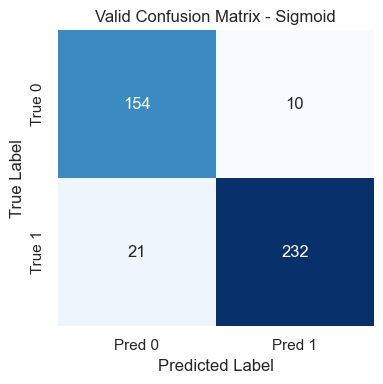

Valid

[Isotonic] Best Threshold: 0.30 (F1: 0.9374)
[Isotonic] Accuracy: 0.9256594724220624
[Isotonic] Brier Score: 0.057778939755463804
[Isotonic] Confusion Matrix:
 [[154  10]
 [ 21 232]]
[Isotonic] Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       164
           1       0.96      0.92      0.94       253

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417



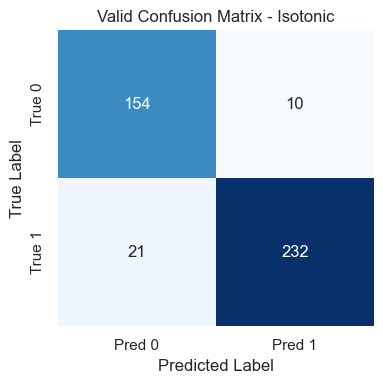

In [ ]:
calib_sigmoid.fit(X_valid, y_valid)
calib_isotonic.fit(X_valid, y_valid)

# 확률 예측
proba_sigmoid_valid = calib_sigmoid.predict_proba(X_valid)[:, 1]
proba_isotonic_valid = calib_isotonic.predict_proba(X_valid)[:, 1]

# threshold 최적화 함수
def find_best_threshold(y_true, proba):
    thresholds = np.arange(0.30, 0.70, 0.01)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_thresh, best_f1 = t, f1
    return best_thresh, best_f1

# 평가 및 confusion matrix 시각화
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

for name, proba in [('Sigmoid', proba_sigmoid_valid), ('Isotonic', proba_isotonic_valid)]:
    thresh, best_f1 = find_best_threshold(y_valid, proba)
    y_pred = (proba >= thresh).astype(int)

    print("Valid")
    print(f"\n[{name}] Best Threshold: {thresh:.2f} (F1: {best_f1:.4f})")
    print(f"[{name}] Accuracy:", accuracy_score(y_valid, y_pred))
    print(f"[{name}] Brier Score:", brier_score_loss(y_valid, proba))
    print(f"[{name}] Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print(f"[{name}] Classification Report:\n", classification_report(y_valid, y_pred))

    # 🔍 Confusion Matrix 시각화
    plot_conf_matrix(y_valid, y_pred, f"Valid Confusion Matrix - {name}")

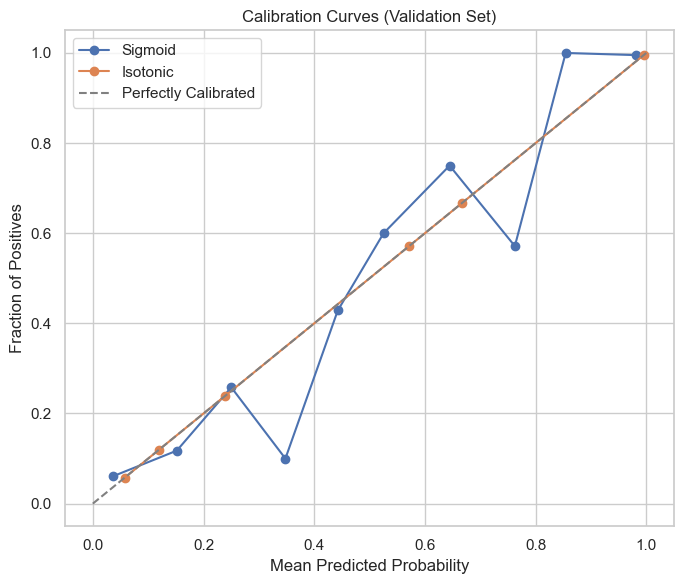

In [ ]:
# Calibration Curve 시각화
plt.figure(figsize=(7, 6))
for proba, label in zip([proba_sigmoid_valid, proba_isotonic_valid], ['Sigmoid', 'Isotonic']):
    prob_true, prob_pred = calibration_curve(y_valid, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'{label}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

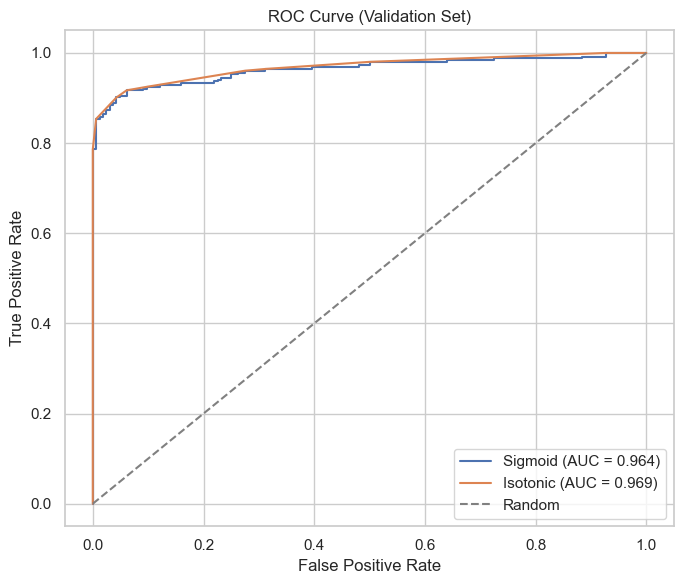

In [ ]:
# Validation AUC 및 ROC Curve
plt.figure(figsize=(7, 6))

for proba, label in zip([proba_sigmoid_valid, proba_isotonic_valid], ['Sigmoid', 'Isotonic']):
    auc = roc_auc_score(y_valid, proba)
    fpr, tpr, _ = roc_curve(y_valid, proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## test

Test

[Sigmoid] Test Best Threshold: 0.42 (F1: 0.8974)
[Sigmoid] Test Accuracy: 0.8953771289537713
[Sigmoid] Test Brier Score: 0.0782919913579135
[Sigmoid] Test Confusion Matrix:
 [[180  19]
 [ 24 188]]
[Sigmoid] Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       199
           1       0.91      0.89      0.90       212

    accuracy                           0.90       411
   macro avg       0.90      0.90      0.90       411
weighted avg       0.90      0.90      0.90       411



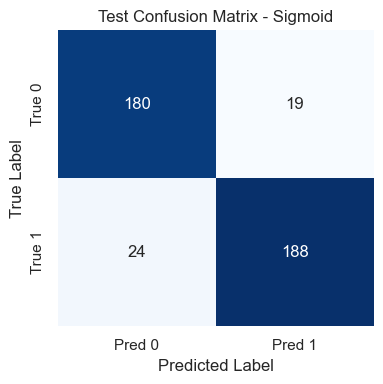

Test

[Isotonic] Test Best Threshold: 0.48 (F1: 0.8964)
[Isotonic] Test Accuracy: 0.8953771289537713
[Isotonic] Test Brier Score: 0.07951534346479995
[Isotonic] Test Confusion Matrix:
 [[182  17]
 [ 26 186]]
[Isotonic] Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       199
           1       0.92      0.88      0.90       212

    accuracy                           0.90       411
   macro avg       0.90      0.90      0.90       411
weighted avg       0.90      0.90      0.90       411



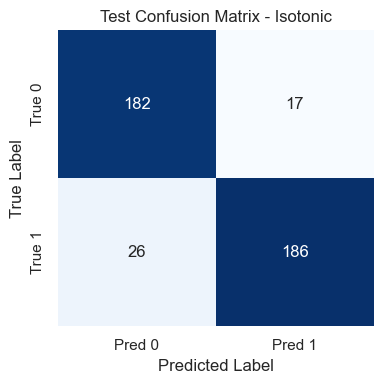

In [ ]:
# 확률 예측 (테스트 세트)
proba_sigmoid_test = calib_sigmoid.predict_proba(X_test)[:, 1]
proba_isotonic_test = calib_isotonic.predict_proba(X_test)[:, 1]

# 각 보정 모델에 대해 threshold 재탐색 (optional)
def find_best_threshold(y_true, proba):
    thresholds = np.arange(0.30, 0.70, 0.01)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_thresh, best_f1 = t, f1
    return best_thresh, best_f1

# 테스트 평가 실행
for name, proba in [('Sigmoid', proba_sigmoid_test), ('Isotonic', proba_isotonic_test)]:
    thresh, best_f1 = find_best_threshold(y_test, proba)
    y_pred = (proba >= thresh).astype(int)

    print("Test")
    print(f"\n[{name}] Test Best Threshold: {thresh:.2f} (F1: {best_f1:.4f})")
    print(f"[{name}] Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"[{name}] Test Brier Score:", brier_score_loss(y_test, proba))
    print(f"[{name}] Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"[{name}] Test Classification Report:\n", classification_report(y_test, y_pred))

    plot_conf_matrix(y_test, y_pred, f"Test Confusion Matrix - {name}")

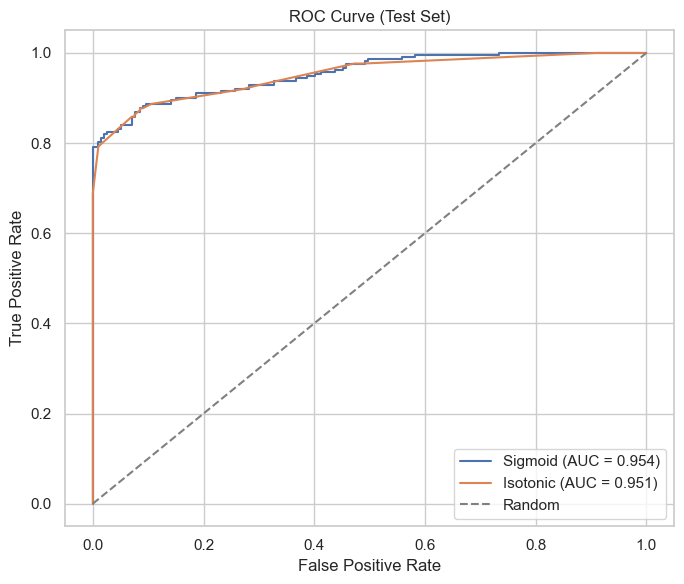

In [ ]:
# Test AUC 및 ROC Curve
plt.figure(figsize=(7, 6))

for proba, label in zip([proba_sigmoid_test, proba_isotonic_test], ['Sigmoid', 'Isotonic']):
    auc = roc_auc_score(y_test, proba)
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Validation AUC (Sigmoid):", roc_auc_score(y_valid, proba_sigmoid_valid))
print("Validation AUC (Isotonic):", roc_auc_score(y_valid, proba_isotonic_valid))

print("Test AUC (Sigmoid):", roc_auc_score(y_test, proba_sigmoid_test))
print("Test AUC (Isotonic):", roc_auc_score(y_test, proba_isotonic_test))

Validation AUC (Sigmoid): 0.9637761496192037
Validation AUC (Isotonic): 0.9689096693338475
Test AUC (Sigmoid): 0.9538020290129895
Test AUC (Isotonic): 0.9507324357637242
mfv AUC (Sigmoid): 0.962262804965045
mfv AUC (Isotonic): 0.9589099728919959


# 4. Eval

In [ ]:
# corr, VIF, PCA, SHAP

# 5. Prediction

In [ ]:
# 1. summarize

# mean, max, mode col -> top/bot 확장
def expand_topbot(base_cols):
    return [f"{col}_top" for col in base_cols] + [f"{col}_bot" for col in base_cols]

# 적용
mean_cols_topbot = expand_topbot(mean_cols)
max_cols_topbot = expand_topbot(max_cols)
mode_cols_topbot = expand_topbot(mode_cols)

print("mean_cols_topbot len : " + str(len(mean_cols_topbot)))
print("max_cols_topbot len : " + str(len(max_cols_topbot)))
print("mode_cols_topbot len : " + str(len(mode_cols_topbot)))


mean_cols_topbot len : 80
max_cols_topbot len : 10
mode_cols_topbot len : 16


In [ ]:
def summarize_prediction_feature(group: pd.DataFrame) -> pd.Series:
    summary = {}

    for col in mean_cols_topbot:
        summary[col] = group[col].mean()

    for col in max_cols_topbot:
        summary[col] = group[col].max()

    for col in mode_cols_topbot:
        summary[col] = safe_mode(group[col])  # 기존에 정의한 mode 함수 사용

    return pd.Series(summary)

fv_a_summary = summarize_prediction_feature(X_fv_a_home)
fv_b_summary = summarize_prediction_feature(X_fv_b_away)

# summarize()로 압축된 Series이기 때문에 1차원 형태라서, 모델 입력 전에 .to_frame().T로 2차원으로 변환
fv_a = fv_a_summary.to_frame().T
fv_b = fv_b_summary.to_frame().T

display(fv_a)
display(fv_b)

,vz0_top,game_type_R_top,p_throws_R_top,bat_score_diff_top,age_pit_top,release_pos_z_top,p_throws_L_top,pfx_x_top,batter_days_since_prev_game_top,of_fielding_alignment_Strategic_top,...,zone_top,strikes_top,pitch_name_bot,outs_when_up_bot,balls_bot,speed_gap_diff_1_bot,pitch_type_bot,type_bot,zone_bot,strikes_bot
0,-3.617581,1.0,0.895793,-0.693616,28.334814,5.746268,0.104207,-0.355493,1.444925,0.004319,...,9.0,0.0,0.0,1.0,0.0,-0.2,6.0,1.0,12.0,0.0


,vz0_top,game_type_R_top,p_throws_R_top,bat_score_diff_top,age_pit_top,release_pos_z_top,p_throws_L_top,pfx_x_top,batter_days_since_prev_game_top,of_fielding_alignment_Strategic_top,...,zone_top,strikes_top,pitch_name_bot,outs_when_up_bot,balls_bot,speed_gap_diff_1_bot,pitch_type_bot,type_bot,zone_bot,strikes_bot
0,-3.298557,1.0,0.71684,0.389402,27.893804,5.856095,0.28316,-0.078356,1.328459,0.011066,...,12.0,0.0,0.0,0.0,0.0,-0.1,6.0,1.0,12.0,0.0


In [ ]:
# 2. is_pitch

pitch_features = [
    'release_speed',  # 투구 속도 (투수 릴리스 시점)
    'release_pos_x',  # 투수 릴리스 위치 (좌우)
    'release_pos_z',  # 투수 릴리스 위치 (높이)
    'release_pos_y',  # 투수 릴리스 위치 (홈과의 거리)
    'pfx_x',  # 투구의 좌우 변화량
    'pfx_z',  # 투구의 상하 변화량
    'vx0',  # 투구 초기 속도 x축 성분
    'vy0',  # 투구 초기 속도 y축 성분
    'vz0',  # 투구 초기 속도 z축 성분
    'ax',  # 투구 가속도 x축
    'ay',  # 투구 가속도 y축
    'az',  # 투구 가속도 z축
    'effective_speed',  # 타자가 느끼는 실질적인 공의 속도
    'release_spin_rate',  # 릴리스 순간의 회전수
    'release_extension',  # 릴리스 지점과 홈플레이트 사이 거리
    'spin_axis',  # 공의 회전축 (구질의 방향성)
    'arm_angle',  # 투수 팔의 릴리스 각도
    'age_pit',  # 투수 나이
    'pitcher_days_since_prev_game',  # 투수의 마지막 등판 이후 휴식일 수
    'api_break_z_with_gravity',  # 중력 포함 투구 낙폭 (낙차)
    'api_break_x_arm',  # 투수 기준 좌우 변화량
    'p_throws_L',  # 투수가 왼손잡이인지 여부 (One-hot)
    'p_throws_R',  # 투수가 오른손잡이인지 여부 (One-hot)
    'game_type_R',  # 경기 타입이 정규시즌(R)인지 여부 (정규 메타정보)
    'n_thruorder_pitcher',  # 해당 투수가 타자 라인업을 몇 번째 도는 중인지
    'if_fielding_alignment_Standard',  # 내야 수비 스탠다드 여부
    'if_fielding_alignment_Strategic',  # 내야 수비 전략적 배치 여부
    'of_fielding_alignment_Standard',  # 외야 수비 스탠다드 여부
    'of_fielding_alignment_Strategic'  # 외야 수비 전략적 배치 여부
]

swing_features = [
    'plate_x',  # 공이 홈플레이트 기준 좌우 어디를 통과했는지
    'plate_z',  # 공이 홈플레이트 기준 어느 높이를 통과했는지
    'balls',  # 현재 볼 카운트
    'strikes',  # 현재 스트라이크 카운트
    'outs_when_up',  # 타석 시점 아웃 카운트
    'bat_score_diff',  # 타석 시점 점수차 (타자 팀 기준)
    'api_break_x_batter_in',  # 타자 기준으로 몸쪽으로 휘는 정도
    'age_bat',  # 타자 나이
    'batter_days_since_prev_game',  # 타자의 마지막 출전 이후 휴식일 수
    'stand_L',  # 타자가 왼손잡이인지 여부 (One-hot)
    'stand_R',  # 타자가 오른손잡이인지 여부 (One-hot)
    'at_bat_number',  # 이 경기에서의 타석 번호
    'n_priorpa_thisgame_player_at_bat',  # 이 경기에서의 타자의 이전 타석 수
    'pitch_type',  # 투구 타입 코드 (ex. 'FF' 등)
    'zone',  # 스트라이크 존 번호 (1~14)
    'type',  # 결과 타입 (B: 볼, S: 스트라이크, X: 인플레이)
    'pitch_name',  # 구질 명칭 (ex. 4-Seam Fastball)
    'sz_top',  # 타자 기준 스트라이크 존 상단
    'sz_bot'   # 타자 기준 스트라이크 존 하단
]
'''
taf_pitch_cols = [
    'spin_efficiency_rolling_avg_5', 'spin_efficiency_lag_1', 'spin_efficiency_diff_1',
    'speed_gap_rolling_avg_5', 'speed_gap_lag_1', 'speed_gap_diff_1',
    'release_pos_angle_rolling_avg_5', 'release_pos_angle_lag_1', 'release_pos_angle_diff_1',
    'init_velocity_vector_rolling_avg_5', 'init_velocity_vector_lag_1', 'init_velocity_vector_diff_1',
    'pitch_movement_vector_rolling_avg_5', 'pitch_movement_vector_lag_1', 'pitch_movement_vector_diff_1',
    'speed_per_extension_rolling_avg_5', 'speed_per_extension_lag_1', 'speed_per_extension_diff_1',
    'release_mechanics_profile_rolling_avg_5', 'release_mechanics_profile_lag_1', 'release_mechanics_profile_diff_1',
    'vertical_spin_effect_rolling_avg_5', 'vertical_spin_effect_lag_1', 'vertical_spin_effect_diff_1',
    'horizontal_spin_effect_rolling_avg_5', 'horizontal_spin_effect_lag_1', 'horizontal_spin_effect_diff_1'
]
taf_swing_cols = [
    'plate_distance_rolling_avg_5', 'plate_distance_lag_1', 'plate_distance_diff_1'
]
'''

# pitch/swing 구분 키워드 정의 (기준 키워드)
pitch_keywords = [
    'spin_efficiency', 'speed_gap', 'release_pos_angle',
    'init_velocity_vector', 'pitch_movement_vector',
    'speed_per_extension', 'release_mechanics_profile',
    'vertical_spin_effect', 'horizontal_spin_effect'
]
swing_keywords = ['plate_distance']

# selected_taf_cols를 기준으로 분류
taf_pitch_cols = [col for col in selected_taf_cols if any(key in col for key in pitch_keywords)]
taf_swing_cols = [col for col in selected_taf_cols if any(key in col for key in swing_keywords)]

# pitch/swing feature 확장
pitch_features += taf_pitch_cols
swing_features += taf_swing_cols

# 확인
print(f"📌 pitch_features 총 개수: {len(pitch_features)}")
print(f"📌 swing_features 총 개수: {len(swing_features)}")

print("\n🎯 추가된 TAF pitch features:")
print(taf_pitch_cols)

print("\n🎯 추가된 TAF swing features:")
print(taf_swing_cols)


📌 pitch_features 총 개수: 33
📌 swing_features 총 개수: 20

🎯 추가된 TAF pitch features:
['spin_efficiency_rolling_avg_5', 'speed_gap_diff_1', 'pitch_movement_vector_rolling_avg_5', 'vertical_spin_effect_lag_1']

🎯 추가된 TAF swing features:
[]


In [ ]:
# 전체 feature 리스트 (fv_a.columns 로부터)
all_features = fv_a.columns.tolist()

def filter_for_prediction(fv_row: pd.DataFrame, mode: str, pitch_features, swing_features):
    assert mode in ['home', 'away'], "mode must be 'home' or 'away'"
    
    # 전체 feature 리스트
    all_features = fv_row.columns.tolist()

    # pitch/swing 전체 top/bot 컬럼명
    pitch_features_tb = [f"{feat}_{suffix}" for feat in pitch_features for suffix in ['top', 'bot']]
    swing_features_tb = [f"{feat}_{suffix}" for feat in swing_features for suffix in ['top', 'bot']]

    # 각 feature가 pitch인지 여부
    is_pitch = [feat in pitch_features_tb for feat in all_features]

    # 필터 조건 구성
    keep_mask = []
    for col, pitch_flag in zip(all_features, is_pitch):
        if mode == 'home':
            if col.endswith('_top') and pitch_flag:
                keep_mask.append(True)  # pitch_top → 남긴다
                
            elif col.endswith('_bot') and not pitch_flag:
                keep_mask.append(True)  # swing_bot → 남긴다
                
            else:
                keep_mask.append(False) # 나머지는 제거
                
        elif mode == 'away':
            if col.endswith('_top') and not pitch_flag: 
                keep_mask.append(True) # swing_top → 남긴다
                
            elif col.endswith('_bot') and pitch_flag: 
                keep_mask.append(True) # pitch_bot → 남긴다
                
            else:
                keep_mask.append(False) # 나머지는 제거

    # 필터링 적용
    filtered_row = fv_row.loc[:, keep_mask]

    return filtered_row

fv_a_filtered = filter_for_prediction(fv_a, mode='home', pitch_features=pitch_features, swing_features=swing_features)
fv_b_filtered = filter_for_prediction(fv_b, mode='away', pitch_features=pitch_features, swing_features=swing_features)

In [ ]:
display(fv_a_filtered)
display(fv_b_filtered)

'''
# feature-value 쌍으로 변환
fv_compare = pd.DataFrame({
    'fv_a_feature': fv_a_filtered.columns,
    'fv_a_value': fv_a_filtered.iloc[0].values,
    'fv_b_feature': fv_b_filtered.columns,
    'fv_b_value': fv_b_filtered.iloc[0].values
})

# Excel로 저장 (동일 시트)
fv_compare.to_excel("fv_filtered.xlsx", sheet_name="fv_compare", index=False)
'''

,vz0_top,game_type_R_top,p_throws_R_top,age_pit_top,release_pos_z_top,p_throws_L_top,pfx_x_top,of_fielding_alignment_Strategic_top,api_break_z_with_gravity_top,spin_axis_top,...,n_priorpa_thisgame_player_at_bat_bot,pitch_number_bot,speed_gap_diff_1_top,pitch_name_bot,outs_when_up_bot,balls_bot,pitch_type_bot,type_bot,zone_bot,strikes_bot
0,-3.617581,1.0,0.895793,28.334814,5.746268,0.104207,-0.355493,0.004319,2.04765,193.176338,...,5.0,15.0,0.0,0.0,1.0,0.0,6.0,1.0,12.0,0.0


,bat_score_diff_top,batter_days_since_prev_game_top,sz_bot_top,plate_x_top,plate_z_top,stand_L_top,stand_R_top,age_bat_top,api_break_x_batter_in_top,sz_top_top,...,n_thruorder_pitcher_bot,vertical_spin_effect_lag_1_bot,pitch_name_top,outs_when_up_top,balls_top,pitch_type_top,type_top,zone_top,strikes_top,speed_gap_diff_1_bot
0,0.389402,1.328459,1.588022,0.003324,2.441196,0.512697,0.487303,27.422625,-0.2104,3.418816,...,3.0,413.7,0.0,2.0,0.0,6.0,1.0,12.0,0.0,-0.1


'\n# feature-value 쌍으로 변환\nfv_compare = pd.DataFrame({\n    \'fv_a_feature\': fv_a_filtered.columns,\n    \'fv_a_value\': fv_a_filtered.iloc[0].values,\n    \'fv_b_feature\': fv_b_filtered.columns,\n    \'fv_b_value\': fv_b_filtered.iloc[0].values\n})\n\n# Excel로 저장 (동일 시트)\nfv_compare.to_excel("fv_filtered.xlsx", sheet_name="fv_compare", index=False)\n'

In [ ]:
# 3. concat

# 컬럼 방향으로 결합 → shape: (1, 102)
fv = pd.concat([fv_a_filtered, fv_b_filtered], axis=1)
fv

# 학습 당시 feature 순서로 재정렬
fv_reindex = fv.reindex(columns=feature_order)
fv_reindex

display(fv)
display(fv_reindex)

'''
# feature-value 쌍으로 변환
fv_compare = pd.DataFrame({
    'fv_feature': fv.columns,
    'fv_value': fv.iloc[0].values,
    'fv_reindex_feature': fv_reindex.columns,
    'fv_reindex_value': fv_reindex.iloc[0].values
})

# Excel로 저장 (동일 시트)
fv_compare.to_excel("fv.xlsx", sheet_name="fv_compare", index=False)
'''

,vz0_top,game_type_R_top,p_throws_R_top,age_pit_top,release_pos_z_top,p_throws_L_top,pfx_x_top,of_fielding_alignment_Strategic_top,api_break_z_with_gravity_top,spin_axis_top,...,n_thruorder_pitcher_bot,vertical_spin_effect_lag_1_bot,pitch_name_top,outs_when_up_top,balls_top,pitch_type_top,type_top,zone_top,strikes_top,speed_gap_diff_1_bot
0,-3.617581,1.0,0.895793,28.334814,5.746268,0.104207,-0.355493,0.004319,2.04765,193.176338,...,3.0,413.7,0.0,2.0,0.0,6.0,1.0,12.0,0.0,-0.1


,vz0_top,vz0_bot,game_type_R_top,game_type_R_bot,p_throws_R_top,p_throws_R_bot,bat_score_diff_top,bat_score_diff_bot,age_pit_top,age_pit_bot,...,speed_gap_diff_1_top,speed_gap_diff_1_bot,pitch_type_top,pitch_type_bot,type_top,type_bot,zone_top,zone_bot,strikes_top,strikes_bot
0,-3.617581,-4.14491,1.0,1.0,0.895793,0.773349,0.389402,0.460441,28.334814,28.605289,...,0.0,-0.1,6.0,6.0,1.0,1.0,12.0,12.0,0.0,0.0


'\n# feature-value 쌍으로 변환\nfv_compare = pd.DataFrame({\n    \'fv_feature\': fv.columns,\n    \'fv_value\': fv.iloc[0].values,\n    \'fv_reindex_feature\': fv_reindex.columns,\n    \'fv_reindex_value\': fv_reindex.iloc[0].values\n})\n\n# Excel로 저장 (동일 시트)\nfv_compare.to_excel("fv.xlsx", sheet_name="fv_compare", index=False)\n'

## Single Match

In [ ]:
'''
calib_sigmoid
calib_isotonic
'''

# 예측
proba_sigmoid = calib_sigmoid.predict_proba(fv_reindex)[0]
proba_isotonic = calib_isotonic.predict_proba(fv_reindex)[0]
# 이건 fv가 하나의 샘플(1 row)이므로, predict_proba(fv) 결과는 (1, 2) shape의 배열입니다.
# [0]을 붙이면 그 중 첫 번째 (그리고 유일한) row인 확률 벡터 ex) [0.36, 0.64]를 꺼냅니다.

In [ ]:
print(f"proba_sigmoid win probability")
print(f"{pred_month}/{pred_date} {a}(Home) {proba_sigmoid[1]:.2f} : {b}(Away) {proba_sigmoid[0]:.2f}")
print()
print(f"proba_isotonic win probability")
print(f"{pred_month}/{pred_date} {a}(Home) {proba_isotonic[1]:.2f} : {b}(Away) {proba_isotonic[0]:.2f}")

proba_sigmoid win probability
6/2025-06-21 00:00:00 TB(Home) 0.74 : DET(Away) 0.26

proba_isotonic win probability
6/2025-06-21 00:00:00 TB(Home) 0.67 : DET(Away) 0.33


## Multiple Match

In [ ]:
# 1. Feature + Meta 불러오기

# 2. Meta 분리 (컬럼명은 실제 데이터에 맞게 조정하세요)
meta_cols = [
 'home_team',
 'away_team',
 'game_date',
 'label']

meta = df[meta_cols]
y_true = meta['label']

X_fv = df.drop(columns=meta_cols)

# 3. feature 정렬 (학습 시 feature 순서대로)
X_fv = X_fv.reindex(columns=feature_order)

KeyError: "None of [Index(['home_team', 'away_team', 'game_date', 'label'], dtype='object')] are in the [columns]"

In [ ]:
# 4. 예측
y_pred_sigmoid = calib_sigmoid.predict_proba(X_fv)
y_pred_isotonic = calib_isotonic.predict_proba(X_fv)

# 5. 결과 정리
meta = meta.reset_index(drop=True)  # 안전하게
result_df = meta.copy()
result_df['home_win_proba_sigmoid'] = y_pred_sigmoid[:, 1]  # [home 확률]
result_df['home_win_proba_isotonic'] = y_pred_isotonic[:, 1]


'''# 결과 CSV로 저장
result_df.to_csv("prediction_results_20250601_0619.csv", index=False)'''

'# 결과 CSV로 저장\nresult_df.to_csv("prediction_results_20250601_0619.csv", index=False)'


[Sigmoid Calibration] Threshold: 0.50
[Sigmoid Calibration] Accuracy: 0.5622
[Sigmoid Calibration] Confusion Matrix:
[[55 36]
 [52 58]]
[Sigmoid Calibration] Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.56        91
           1       0.62      0.53      0.57       110

    accuracy                           0.56       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.57      0.56      0.56       201



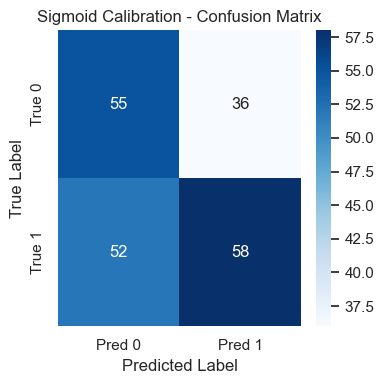


[Isotonic Calibration] Threshold: 0.50
[Isotonic Calibration] Accuracy: 0.5622
[Isotonic Calibration] Confusion Matrix:
[[55 36]
 [52 58]]
[Isotonic Calibration] Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.56        91
           1       0.62      0.53      0.57       110

    accuracy                           0.56       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.57      0.56      0.56       201



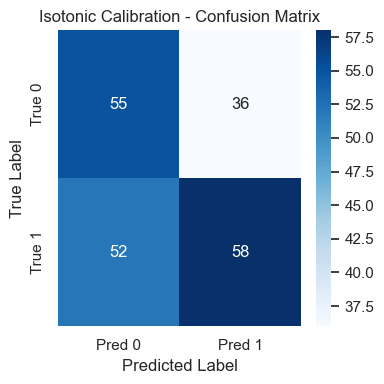

In [ ]:
def evaluate_predictions(y_true, y_proba, threshold=0.5, title="General"):
    """
    y_true: 실제 라벨 (0 또는 1)
    y_proba: 모델의 확률 예측 (0.0 ~ 1.0)
    threshold: 분류 임계값
    title: 시각화 제목용 텍스트
    """
    y_pred = (y_proba >= threshold).astype(int)

    print("General")
    print(f"\n[{title}] Threshold: {threshold:.2f}")
    print(f"[{title}] Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"[{title}] Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"[{title}] Classification Report:\n{classification_report(y_true, y_pred)}")

    # Confusion Matrix 시각화
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f"{title} -General Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


# sigmoid 평가
evaluate_predictions(y_true, y_pred_sigmoid[:, 1], title="Sigmoid Calibration")

# isotonic 평가
evaluate_predictions(y_true, y_pred_isotonic[:, 1], title="Isotonic Calibration")

